In [48]:
import numpy as np
import matplotlib.pyplot as plt

from time import time
# from hnc_custom_screeningOZ_multiscale import  HNC_solver
from hnc_Ng import  HNC_solver
from qsps import *

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
        
        
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
def set_hnc_onlyion(n_in_per_cc, T, Z, A, Zstar, c_k_guess=None , which_Tij='thermal',
            oz_type='standard', method='kryov', add_bridge=False, bridge='yukawa',
            pseudopotential=False, r_c=0.6, no_coupling=False, N_bins = 500, R_max=5):
    
    n_in_AU = n_in_per_cc*1e6 *aB**3
    ri = QSP_HNC.rs_from_n(n_in_AU)
    qsp = QSP_HNC(Z, A, Zstar, T, T, ri, Zstar*n_in_AU, which_Tij=which_Tij, r_c=r_c)

    N_species = 1
    Gamma = np.array(  [[qsp.Γii]])


    names = ["Ion-1", "Electron", ] 
    kappa = 1
    
    rhos = np.array([  3/(4*np.pi)])
    temps = np.array([qsp.Ti])
    masses= np.array([qsp.m_i])
    hnc1 = HNC_solver(N_species, Gamma, rhos, temps, masses ,
                     kappa_multiscale=5, R_max=R_max, N_bins=N_bins, 
                      names=names, dst_type=3, oz_method=oz_type)

    if pseudopotential==True:
        βvei = qsp.βvei_atomic(hnc1.r_array)
    else:
        βvei = qsp.βvei(hnc1.r_array)
    βu_r_matrix = np.array([[qsp.βvii(hnc1.r_array)]])
    if no_coupling:
        βu_r_matrix[0,1]=0
        βu_r_matrix[1,0]=0
    
    if add_bridge:
        if bridge=='ocp':
            βu_r_matrix[0,0] = βu_r_matrix[0,0] - hnc1.Bridge_function_OCP(hnc1.r_array, qsp.Γii)
        elif bridge=='yukawa':
            βu_r_matrix[0,0] = βu_r_matrix[0,0] - hnc1.Bridge_function_Yukawa(hnc1.r_array, qsp.Γii, qsp.get_κ())
    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    if c_k_guess is not None:
        for i in range(N_species):
            for j in range(N_species):
                if (c_k_guess[i,j]!=np.zeros(hnc1.N_bins)).all():
#                 if i==j:
                    hnc1.c_k_matrix[i,j] = c_k_guess[i,j]
                    hnc1.c_r_matrix[i,j] = hnc1.FT_k_2_r(hnc1.c_k_matrix[i,j])
                    hnc1.c_s_k_matrix[i,j] = hnc1.c_k_matrix[i,j] + hnc1.βu_l_k_matrix[i,j]
                    hnc1.c_s_r_matrix[i,j] = hnc1.c_r_matrix[i,j] + hnc1.βu_l_r_matrix[i,j]

#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    hnc1.set_C_matrix()

    return hnc1, qsp

# Priority 1

## atom

In [6]:
mixture_file = "/home/zach/plasma/hnc/data/TCCW_single_species_data.csv"
tccw_mixture_data = read_csv(mixture_file)
tccw_cases = [tccw_mixture_data.iloc[n] for n in range(len(tccw_mixture_data))]

for tccw_case in tccw_cases:
    if 'H' in tccw_case['Case ID']:
        print(tccw_case[' '], tccw_case['Case ID'], " Γii = ",tccw_case['Coupling Constant'])
        

0 H1  Γii =  4.689931802
6 H2  Γii =  385.7474933
7 H3  Γii =  1.505398501
14 H11  Γii =  1238.853127
15 H21  Γii =  2974.224527
16 H31  Γii =  7571.846897
26 H12  Γii =  123.8925534
27 H22  Γii =  297.4237281
28 H32  Γii =  757.1848093
38 H13  Γii =  12.40787488
39 H23  Γii =  29.74600211
40 H33  Γii =  75.71886645
50 H14  Γii =  1.296884499
51 H24  Γii =  2.985299562
52 H34  Γii =  7.572905589
62 H15  Γii =  0.197649761
63 H25  Γii =  0.33817545
64 H35  Γii =  0.762807904
74 H16  Γii =  0.001159757


In [8]:
case_successes = {}
SVT_case_successes = {}
R_max = 10
N_bins = 500
max_attempts=1

tccw_case = tccw_cases[28]
α = 0.1
case_converged=False
case_attempts=0
case_num= tccw_case[' ']
case_id = tccw_case['Case ID']
ni = tccw_case['Number Density [N/cc]']
Te = tccw_case['Temperature [eV]']*eV
Ti = Te
Z = tccw_case['Atomic Number']
Zstar = tccw_case['Zbar (TFDW)']
A = tccw_case['Atomic Weight [a.u.]']
r_s = tccw_case['Wigner-Seitz Radius [cm]']
r_c = tccw_case['Average-Bound Radius [cm]']/r_s

print('\n______________________________\nCase num: {0} Case ID: {1}'.format(case_num, case_id))
print("Te = {0:.3e} eV, n_i = {1:.3e} 1/cc, r_c/r_s = {2:.3f}".format(Te/eV, ni, r_c))



______________________________
Case num: 28 Case ID: H32
Te = 1.000e-01 eV, n_i = 5.700e+25 1/cc, r_c/r_s = 0.525


In [51]:
c_k_matrix_list = []
h_k_matrix_list = []
atom_list = []
T_max = 10*Te
T_min = 0.1*Te
Te_list = np.linspace(Te, T_max, num=10)[::-1]
N_bins, R_max= 1000, 10
for index, Te_annealed in enumerate(Te_list):
    t0=time()
    print("\nIndex ", index,":")
    print("__________________________\nTe = {0:.3e} eV, n_i = {1:.3e} 1/cc, r_c/r_s = {2:.3f}".format(Te_annealed/eV, ni, r_c))
    atom, qsp = set_hnc_onlyion(ni, Te_annealed, Z, A, Zstar, 
                            pseudopotential=True, oz_type='svt',r_c=r_c, 
                            add_bridge=True, bridge='ocp', N_bins=N_bins, R_max=R_max)

#     if index>0:
#         atom.h_k_matrix = h_k_matrix_list[-1].copy()#(h_k_matrix_list[-1]-h_k_matrix_list[-2])/(Te_list[index-1]-Te_list[index-])
#         atom.c_s_k_matrix  = atom.invert_SVT(atom.h_k_matrix, -atom.βu_s_k_matrix)
#         alpha_Picard = 1e-3
#     if index>1:
#         atom.h_k_matrix = h_k_matrix_list[-1] + (Te_annealed-Te_list[index-1])*(h_k_matrix_list[-1]-h_k_matrix_list[-2])/(Te_list[index-1]-Te_list[index-2])
#         atom.c_s_k_matrix  = atom.invert_SVT(atom.h_k_matrix, -atom.βu_s_k_matrix)
#         alpha_Picard = 1e-3
    atom.c_s_k_matrix*=0
    atom.HNC_solve(alpha_method='fixed', alpha_Picard = 0.5, tol=1e-6, alpha_Ng=0.1, 
               iters_to_wait=1e4, iters_to_use=2, num_iterations=1e3, verbose=True)
   
    if atom.total_err(sol.x.reshape(1,1,N_bins))>2e-6:
        options={'eps':1e-6,'maxfev':10000,'factor':1,'xtol':1e-8} 
        newton_kwargs= {'method':'hybr', 'options':options} 
        sol = atom.HNC_newton_solve( **newton_kwargs)
        print("Err: ", atom.total_err(sol.x.reshape(1,1,N_bins)))

    #     if atom.newton_succeed==False:
#         break
    atom_list.append(atom)
    c_k_matrix_list.append(atom.c_k_matrix.copy())
    h_k_matrix_list.append(atom.h_k_matrix.copy())
    print("Case Time: {0:.3e} s ".format(time()-t0))


Index  0 :
__________________________
Te = 1.000e+00 eV, n_i = 5.700e+25 1/cc, r_c/r_s = 0.525
Λei = 0.353
Λee = 0.500
Λei adjusted with R = 0.353
Γii=86.140, Γie=-0.235, Γee=0.239 
r_i=0.305
r_e=0.306
r_c=0.525
θ  =1.87e-03
0: Initial condition Total Error: 1.161e+01
1: Change in c_r: 2.310e-01, HNC Error: 3.841e-02, Total Error: 8.412e+00
2: Change in c_r: 2.180e-01, HNC Error: 4.595e-02, Total Error: 6.301e+00
3: Change in c_r: 2.120e-01, HNC Error: 5.246e-02, Total Error: 4.874e+00
4: Change in c_r: 2.157e-01, HNC Error: 3.697e-02, Total Error: 3.867e+00
5: Change in c_r: 2.316e-01, HNC Error: 7.515e-02, Total Error: 3.121e+00
6: Change in c_r: 2.522e-01, HNC Error: 1.144e-01, Total Error: 2.557e+00
7: Change in c_r: 2.651e-01, HNC Error: 1.001e-01, Total Error: 2.147e+00
8: Change in c_r: 2.682e-01, HNC Error: 7.483e-02, Total Error: 1.863e+00
9: Change in c_r: 2.653e-01, HNC Error: 6.091e-02, Total Error: 1.670e+00
10: Change in c_r: 2.597e-01, HNC Error: 5.559e-02, Total Error:

107: Change in c_r: 3.589e-02, HNC Error: 1.639e-03, Total Error: 6.945e-02
108: Change in c_r: 3.520e-02, HNC Error: 1.603e-03, Total Error: 6.800e-02
109: Change in c_r: 3.452e-02, HNC Error: 1.568e-03, Total Error: 6.658e-02
110: Change in c_r: 3.386e-02, HNC Error: 1.534e-03, Total Error: 6.519e-02
111: Change in c_r: 3.321e-02, HNC Error: 1.501e-03, Total Error: 6.383e-02
112: Change in c_r: 3.257e-02, HNC Error: 1.468e-03, Total Error: 6.251e-02
113: Change in c_r: 3.194e-02, HNC Error: 1.437e-03, Total Error: 6.121e-02
114: Change in c_r: 3.133e-02, HNC Error: 1.406e-03, Total Error: 5.995e-02
115: Change in c_r: 3.073e-02, HNC Error: 1.376e-03, Total Error: 5.871e-02
116: Change in c_r: 3.014e-02, HNC Error: 1.346e-03, Total Error: 5.750e-02
117: Change in c_r: 2.956e-02, HNC Error: 1.318e-03, Total Error: 5.631e-02
118: Change in c_r: 2.899e-02, HNC Error: 1.290e-03, Total Error: 5.516e-02
119: Change in c_r: 2.844e-02, HNC Error: 1.262e-03, Total Error: 5.402e-02
120: Change 

215: Change in c_r: 4.440e-03, HNC Error: 1.808e-04, Total Error: 7.971e-03
216: Change in c_r: 4.355e-03, HNC Error: 1.773e-04, Total Error: 7.817e-03
217: Change in c_r: 4.272e-03, HNC Error: 1.738e-04, Total Error: 7.666e-03
218: Change in c_r: 4.190e-03, HNC Error: 1.705e-04, Total Error: 7.517e-03
219: Change in c_r: 4.109e-03, HNC Error: 1.671e-04, Total Error: 7.372e-03
220: Change in c_r: 4.031e-03, HNC Error: 1.639e-04, Total Error: 7.229e-03
221: Change in c_r: 3.953e-03, HNC Error: 1.607e-04, Total Error: 7.089e-03
222: Change in c_r: 3.877e-03, HNC Error: 1.576e-04, Total Error: 6.952e-03
223: Change in c_r: 3.803e-03, HNC Error: 1.545e-04, Total Error: 6.818e-03
224: Change in c_r: 3.730e-03, HNC Error: 1.515e-04, Total Error: 6.686e-03
225: Change in c_r: 3.659e-03, HNC Error: 1.486e-04, Total Error: 6.557e-03
226: Change in c_r: 3.588e-03, HNC Error: 1.457e-04, Total Error: 6.430e-03
227: Change in c_r: 3.520e-03, HNC Error: 1.429e-04, Total Error: 6.306e-03
228: Change 

323: Change in c_r: 5.480e-04, HNC Error: 2.203e-05, Total Error: 9.753e-04
324: Change in c_r: 5.375e-04, HNC Error: 2.160e-05, Total Error: 9.566e-04
325: Change in c_r: 5.272e-04, HNC Error: 2.119e-05, Total Error: 9.382e-04
326: Change in c_r: 5.171e-04, HNC Error: 2.078e-05, Total Error: 9.202e-04
327: Change in c_r: 5.071e-04, HNC Error: 2.038e-05, Total Error: 9.025e-04
328: Change in c_r: 4.974e-04, HNC Error: 1.999e-05, Total Error: 8.851e-04
329: Change in c_r: 4.879e-04, HNC Error: 1.960e-05, Total Error: 8.681e-04
330: Change in c_r: 4.785e-04, HNC Error: 1.923e-05, Total Error: 8.515e-04
331: Change in c_r: 4.693e-04, HNC Error: 1.886e-05, Total Error: 8.351e-04
332: Change in c_r: 4.603e-04, HNC Error: 1.850e-05, Total Error: 8.191e-04
333: Change in c_r: 4.515e-04, HNC Error: 1.814e-05, Total Error: 8.033e-04
334: Change in c_r: 4.428e-04, HNC Error: 1.779e-05, Total Error: 7.879e-04
335: Change in c_r: 4.343e-04, HNC Error: 1.745e-05, Total Error: 7.727e-04
336: Change 

431: Change in c_r: 6.757e-05, HNC Error: 2.712e-06, Total Error: 1.201e-04
432: Change in c_r: 6.627e-05, HNC Error: 2.659e-06, Total Error: 1.178e-04
433: Change in c_r: 6.500e-05, HNC Error: 2.608e-06, Total Error: 1.156e-04
434: Change in c_r: 6.375e-05, HNC Error: 2.558e-06, Total Error: 1.133e-04
435: Change in c_r: 6.253e-05, HNC Error: 2.509e-06, Total Error: 1.112e-04
436: Change in c_r: 6.133e-05, HNC Error: 2.461e-06, Total Error: 1.090e-04
437: Change in c_r: 6.015e-05, HNC Error: 2.414e-06, Total Error: 1.069e-04
438: Change in c_r: 5.899e-05, HNC Error: 2.367e-06, Total Error: 1.049e-04
439: Change in c_r: 5.786e-05, HNC Error: 2.322e-06, Total Error: 1.029e-04
440: Change in c_r: 5.675e-05, HNC Error: 2.277e-06, Total Error: 1.009e-04
441: Change in c_r: 5.566e-05, HNC Error: 2.234e-06, Total Error: 9.896e-05
442: Change in c_r: 5.459e-05, HNC Error: 2.191e-06, Total Error: 9.706e-05
443: Change in c_r: 5.355e-05, HNC Error: 2.149e-06, Total Error: 9.519e-05
444: Change 

539: Change in c_r: 8.330e-06, HNC Error: 3.342e-07, Total Error: 1.481e-05
540: Change in c_r: 8.170e-06, HNC Error: 3.278e-07, Total Error: 1.452e-05
541: Change in c_r: 8.013e-06, HNC Error: 3.215e-07, Total Error: 1.424e-05
542: Change in c_r: 7.859e-06, HNC Error: 3.153e-07, Total Error: 1.397e-05
543: Change in c_r: 7.708e-06, HNC Error: 3.093e-07, Total Error: 1.370e-05
544: Change in c_r: 7.560e-06, HNC Error: 3.033e-07, Total Error: 1.344e-05
545: Change in c_r: 7.415e-06, HNC Error: 2.975e-07, Total Error: 1.318e-05
546: Change in c_r: 7.273e-06, HNC Error: 2.918e-07, Total Error: 1.293e-05
547: Change in c_r: 7.133e-06, HNC Error: 2.862e-07, Total Error: 1.268e-05
548: Change in c_r: 6.996e-06, HNC Error: 2.807e-07, Total Error: 1.244e-05
549: Change in c_r: 6.862e-06, HNC Error: 2.753e-07, Total Error: 1.220e-05
550: Change in c_r: 6.730e-06, HNC Error: 2.700e-07, Total Error: 1.196e-05
551: Change in c_r: 6.601e-06, HNC Error: 2.649e-07, Total Error: 1.173e-05
552: Change 

647: Change in c_r: 1.027e-06, HNC Error: 4.120e-08, Total Error: 1.825e-06
648: Change in c_r: 1.007e-06, HNC Error: 4.041e-08, Total Error: 1.790e-06
649: Change in c_r: 9.878e-07, HNC Error: 3.963e-08, Total Error: 1.756e-06
650: Change in c_r: 9.689e-07, HNC Error: 3.887e-08, Total Error: 1.722e-06
651: Change in c_r: 9.503e-07, HNC Error: 3.813e-08, Total Error: 1.689e-06
652: Change in c_r: 9.320e-07, HNC Error: 3.739e-08, Total Error: 1.657e-06
653: Change in c_r: 9.141e-07, HNC Error: 3.668e-08, Total Error: 1.625e-06
654: Change in c_r: 8.966e-07, HNC Error: 3.597e-08, Total Error: 1.594e-06
655: Change in c_r: 8.794e-07, HNC Error: 3.528e-08, Total Error: 1.563e-06
656: Change in c_r: 8.625e-07, HNC Error: 3.460e-08, Total Error: 1.533e-06
657: Change in c_r: 8.459e-07, HNC Error: 3.394e-08, Total Error: 1.504e-06
658: Change in c_r: 8.297e-07, HNC Error: 3.329e-08, Total Error: 1.475e-06
659: Change in c_r: 8.138e-07, HNC Error: 3.265e-08, Total Error: 1.447e-06
660: Change 

755: Change in c_r: 1.266e-07, HNC Error: 5.079e-09, Total Error: 2.250e-07
756: Change in c_r: 1.242e-07, HNC Error: 4.981e-09, Total Error: 2.207e-07
757: Change in c_r: 1.218e-07, HNC Error: 4.886e-09, Total Error: 2.165e-07
758: Change in c_r: 1.194e-07, HNC Error: 4.792e-09, Total Error: 2.123e-07
759: Change in c_r: 1.171e-07, HNC Error: 4.700e-09, Total Error: 2.082e-07
760: Change in c_r: 1.149e-07, HNC Error: 4.610e-09, Total Error: 2.042e-07
761: Change in c_r: 1.127e-07, HNC Error: 4.521e-09, Total Error: 2.003e-07
762: Change in c_r: 1.105e-07, HNC Error: 4.435e-09, Total Error: 1.965e-07
763: Change in c_r: 1.084e-07, HNC Error: 4.349e-09, Total Error: 1.927e-07
764: Change in c_r: 1.063e-07, HNC Error: 4.266e-09, Total Error: 1.890e-07
765: Change in c_r: 1.043e-07, HNC Error: 4.184e-09, Total Error: 1.854e-07
766: Change in c_r: 1.023e-07, HNC Error: 4.104e-09, Total Error: 1.818e-07
767: Change in c_r: 1.003e-07, HNC Error: 4.025e-09, Total Error: 1.783e-07
768: Change 

863: Change in c_r: 1.561e-08, HNC Error: 6.261e-10, Total Error: 2.774e-08
864: Change in c_r: 1.531e-08, HNC Error: 6.141e-10, Total Error: 2.721e-08
865: Change in c_r: 1.501e-08, HNC Error: 6.023e-10, Total Error: 2.668e-08
866: Change in c_r: 1.472e-08, HNC Error: 5.907e-10, Total Error: 2.617e-08
867: Change in c_r: 1.444e-08, HNC Error: 5.794e-10, Total Error: 2.567e-08
868: Change in c_r: 1.416e-08, HNC Error: 5.683e-10, Total Error: 2.518e-08
869: Change in c_r: 1.389e-08, HNC Error: 5.574e-10, Total Error: 2.469e-08
870: Change in c_r: 1.363e-08, HNC Error: 5.467e-10, Total Error: 2.422e-08
871: Change in c_r: 1.336e-08, HNC Error: 5.362e-10, Total Error: 2.376e-08
872: Change in c_r: 1.311e-08, HNC Error: 5.259e-10, Total Error: 2.330e-08
873: Change in c_r: 1.286e-08, HNC Error: 5.158e-10, Total Error: 2.285e-08
874: Change in c_r: 1.261e-08, HNC Error: 5.059e-10, Total Error: 2.241e-08
875: Change in c_r: 1.237e-08, HNC Error: 4.962e-10, Total Error: 2.198e-08
876: Change 

83: Change in c_r: 6.745e-02, HNC Error: 3.521e-03, Total Error: 1.411e-01
84: Change in c_r: 6.626e-02, HNC Error: 3.440e-03, Total Error: 1.381e-01
85: Change in c_r: 6.509e-02, HNC Error: 3.362e-03, Total Error: 1.353e-01
86: Change in c_r: 6.394e-02, HNC Error: 3.286e-03, Total Error: 1.325e-01
87: Change in c_r: 6.282e-02, HNC Error: 3.212e-03, Total Error: 1.297e-01
88: Change in c_r: 6.171e-02, HNC Error: 3.140e-03, Total Error: 1.271e-01
89: Change in c_r: 6.063e-02, HNC Error: 3.071e-03, Total Error: 1.245e-01
90: Change in c_r: 5.956e-02, HNC Error: 3.003e-03, Total Error: 1.219e-01
91: Change in c_r: 5.852e-02, HNC Error: 2.937e-03, Total Error: 1.195e-01
92: Change in c_r: 5.749e-02, HNC Error: 2.873e-03, Total Error: 1.171e-01
93: Change in c_r: 5.649e-02, HNC Error: 2.811e-03, Total Error: 1.147e-01
94: Change in c_r: 5.550e-02, HNC Error: 2.750e-03, Total Error: 1.124e-01
95: Change in c_r: 5.453e-02, HNC Error: 2.691e-03, Total Error: 1.102e-01
96: Change in c_r: 5.358e

194: Change in c_r: 9.775e-03, HNC Error: 4.055e-04, Total Error: 1.771e-02
195: Change in c_r: 9.608e-03, HNC Error: 3.983e-04, Total Error: 1.740e-02
196: Change in c_r: 9.443e-03, HNC Error: 3.913e-04, Total Error: 1.709e-02
197: Change in c_r: 9.281e-03, HNC Error: 3.843e-04, Total Error: 1.679e-02
198: Change in c_r: 9.122e-03, HNC Error: 3.775e-04, Total Error: 1.650e-02
199: Change in c_r: 8.965e-03, HNC Error: 3.708e-04, Total Error: 1.621e-02
200: Change in c_r: 8.812e-03, HNC Error: 3.643e-04, Total Error: 1.593e-02
201: Change in c_r: 8.660e-03, HNC Error: 3.578e-04, Total Error: 1.565e-02
202: Change in c_r: 8.512e-03, HNC Error: 3.515e-04, Total Error: 1.537e-02
203: Change in c_r: 8.366e-03, HNC Error: 3.453e-04, Total Error: 1.511e-02
204: Change in c_r: 8.222e-03, HNC Error: 3.392e-04, Total Error: 1.484e-02
205: Change in c_r: 8.081e-03, HNC Error: 3.332e-04, Total Error: 1.458e-02
206: Change in c_r: 7.943e-03, HNC Error: 3.273e-04, Total Error: 1.433e-02
207: Change 

302: Change in c_r: 1.507e-03, HNC Error: 6.075e-05, Total Error: 2.681e-03
303: Change in c_r: 1.481e-03, HNC Error: 5.970e-05, Total Error: 2.634e-03
304: Change in c_r: 1.456e-03, HNC Error: 5.867e-05, Total Error: 2.589e-03
305: Change in c_r: 1.431e-03, HNC Error: 5.766e-05, Total Error: 2.544e-03
306: Change in c_r: 1.406e-03, HNC Error: 5.666e-05, Total Error: 2.501e-03
307: Change in c_r: 1.382e-03, HNC Error: 5.568e-05, Total Error: 2.457e-03
308: Change in c_r: 1.358e-03, HNC Error: 5.472e-05, Total Error: 2.415e-03
309: Change in c_r: 1.335e-03, HNC Error: 5.378e-05, Total Error: 2.374e-03
310: Change in c_r: 1.312e-03, HNC Error: 5.285e-05, Total Error: 2.333e-03
311: Change in c_r: 1.289e-03, HNC Error: 5.194e-05, Total Error: 2.292e-03
312: Change in c_r: 1.267e-03, HNC Error: 5.104e-05, Total Error: 2.253e-03
313: Change in c_r: 1.246e-03, HNC Error: 5.016e-05, Total Error: 2.214e-03
314: Change in c_r: 1.224e-03, HNC Error: 4.930e-05, Total Error: 2.176e-03
315: Change 

410: Change in c_r: 2.320e-04, HNC Error: 9.312e-06, Total Error: 4.115e-04
411: Change in c_r: 2.280e-04, HNC Error: 9.152e-06, Total Error: 4.044e-04
412: Change in c_r: 2.241e-04, HNC Error: 8.995e-06, Total Error: 3.975e-04
413: Change in c_r: 2.202e-04, HNC Error: 8.840e-06, Total Error: 3.907e-04
414: Change in c_r: 2.165e-04, HNC Error: 8.688e-06, Total Error: 3.840e-04
415: Change in c_r: 2.127e-04, HNC Error: 8.539e-06, Total Error: 3.774e-04
416: Change in c_r: 2.091e-04, HNC Error: 8.392e-06, Total Error: 3.709e-04
417: Change in c_r: 2.055e-04, HNC Error: 8.248e-06, Total Error: 3.645e-04
418: Change in c_r: 2.020e-04, HNC Error: 8.106e-06, Total Error: 3.582e-04
419: Change in c_r: 1.985e-04, HNC Error: 7.966e-06, Total Error: 3.521e-04
420: Change in c_r: 1.951e-04, HNC Error: 7.829e-06, Total Error: 3.460e-04
421: Change in c_r: 1.917e-04, HNC Error: 7.695e-06, Total Error: 3.401e-04
422: Change in c_r: 1.884e-04, HNC Error: 7.563e-06, Total Error: 3.342e-04
423: Change 

518: Change in c_r: 3.570e-05, HNC Error: 1.432e-06, Total Error: 6.331e-05
519: Change in c_r: 3.509e-05, HNC Error: 1.408e-06, Total Error: 6.222e-05
520: Change in c_r: 3.449e-05, HNC Error: 1.383e-06, Total Error: 6.115e-05
521: Change in c_r: 3.389e-05, HNC Error: 1.360e-06, Total Error: 6.010e-05
522: Change in c_r: 3.331e-05, HNC Error: 1.336e-06, Total Error: 5.907e-05
523: Change in c_r: 3.274e-05, HNC Error: 1.313e-06, Total Error: 5.805e-05
524: Change in c_r: 3.218e-05, HNC Error: 1.291e-06, Total Error: 5.705e-05
525: Change in c_r: 3.162e-05, HNC Error: 1.269e-06, Total Error: 5.607e-05
526: Change in c_r: 3.108e-05, HNC Error: 1.247e-06, Total Error: 5.511e-05
527: Change in c_r: 3.055e-05, HNC Error: 1.225e-06, Total Error: 5.416e-05
528: Change in c_r: 3.002e-05, HNC Error: 1.204e-06, Total Error: 5.323e-05
529: Change in c_r: 2.951e-05, HNC Error: 1.184e-06, Total Error: 5.232e-05
530: Change in c_r: 2.900e-05, HNC Error: 1.163e-06, Total Error: 5.142e-05
531: Change 

626: Change in c_r: 5.494e-06, HNC Error: 2.204e-07, Total Error: 9.742e-06
627: Change in c_r: 5.400e-06, HNC Error: 2.166e-07, Total Error: 9.574e-06
628: Change in c_r: 5.307e-06, HNC Error: 2.129e-07, Total Error: 9.410e-06
629: Change in c_r: 5.216e-06, HNC Error: 2.092e-07, Total Error: 9.248e-06
630: Change in c_r: 5.126e-06, HNC Error: 2.056e-07, Total Error: 9.089e-06
631: Change in c_r: 5.038e-06, HNC Error: 2.021e-07, Total Error: 8.933e-06
632: Change in c_r: 4.952e-06, HNC Error: 1.986e-07, Total Error: 8.780e-06
633: Change in c_r: 4.867e-06, HNC Error: 1.952e-07, Total Error: 8.629e-06
634: Change in c_r: 4.783e-06, HNC Error: 1.918e-07, Total Error: 8.481e-06
635: Change in c_r: 4.701e-06, HNC Error: 1.886e-07, Total Error: 8.335e-06
636: Change in c_r: 4.620e-06, HNC Error: 1.853e-07, Total Error: 8.192e-06
637: Change in c_r: 4.541e-06, HNC Error: 1.821e-07, Total Error: 8.051e-06
638: Change in c_r: 4.463e-06, HNC Error: 1.790e-07, Total Error: 7.913e-06
639: Change 

734: Change in c_r: 8.455e-07, HNC Error: 3.391e-08, Total Error: 1.499e-06
735: Change in c_r: 8.310e-07, HNC Error: 3.333e-08, Total Error: 1.473e-06
736: Change in c_r: 8.167e-07, HNC Error: 3.276e-08, Total Error: 1.448e-06
737: Change in c_r: 8.027e-07, HNC Error: 3.220e-08, Total Error: 1.423e-06
738: Change in c_r: 7.889e-07, HNC Error: 3.164e-08, Total Error: 1.399e-06
739: Change in c_r: 7.754e-07, HNC Error: 3.110e-08, Total Error: 1.375e-06
740: Change in c_r: 7.620e-07, HNC Error: 3.056e-08, Total Error: 1.351e-06
741: Change in c_r: 7.490e-07, HNC Error: 3.004e-08, Total Error: 1.328e-06
742: Change in c_r: 7.361e-07, HNC Error: 2.952e-08, Total Error: 1.305e-06
743: Change in c_r: 7.234e-07, HNC Error: 2.902e-08, Total Error: 1.283e-06
744: Change in c_r: 7.110e-07, HNC Error: 2.852e-08, Total Error: 1.261e-06
745: Change in c_r: 6.988e-07, HNC Error: 2.803e-08, Total Error: 1.239e-06
746: Change in c_r: 6.868e-07, HNC Error: 2.755e-08, Total Error: 1.218e-06
747: Change 

842: Change in c_r: 1.301e-07, HNC Error: 5.219e-09, Total Error: 2.307e-07
843: Change in c_r: 1.279e-07, HNC Error: 5.129e-09, Total Error: 2.267e-07
844: Change in c_r: 1.257e-07, HNC Error: 5.041e-09, Total Error: 2.228e-07
845: Change in c_r: 1.235e-07, HNC Error: 4.955e-09, Total Error: 2.190e-07
846: Change in c_r: 1.214e-07, HNC Error: 4.869e-09, Total Error: 2.153e-07
847: Change in c_r: 1.193e-07, HNC Error: 4.786e-09, Total Error: 2.116e-07
848: Change in c_r: 1.173e-07, HNC Error: 4.704e-09, Total Error: 2.079e-07
849: Change in c_r: 1.153e-07, HNC Error: 4.623e-09, Total Error: 2.043e-07
850: Change in c_r: 1.133e-07, HNC Error: 4.543e-09, Total Error: 2.008e-07
851: Change in c_r: 1.113e-07, HNC Error: 4.465e-09, Total Error: 1.974e-07
852: Change in c_r: 1.094e-07, HNC Error: 4.389e-09, Total Error: 1.940e-07
853: Change in c_r: 1.075e-07, HNC Error: 4.313e-09, Total Error: 1.907e-07
854: Change in c_r: 1.057e-07, HNC Error: 4.239e-09, Total Error: 1.874e-07
855: Change 

950: Change in c_r: 2.002e-08, HNC Error: 8.031e-10, Total Error: 3.550e-08
951: Change in c_r: 1.968e-08, HNC Error: 7.893e-10, Total Error: 3.489e-08
952: Change in c_r: 1.934e-08, HNC Error: 7.758e-10, Total Error: 3.429e-08
953: Change in c_r: 1.901e-08, HNC Error: 7.625e-10, Total Error: 3.370e-08
954: Change in c_r: 1.868e-08, HNC Error: 7.494e-10, Total Error: 3.313e-08
955: Change in c_r: 1.836e-08, HNC Error: 7.365e-10, Total Error: 3.256e-08
956: Change in c_r: 1.805e-08, HNC Error: 7.238e-10, Total Error: 3.200e-08
957: Change in c_r: 1.774e-08, HNC Error: 7.114e-10, Total Error: 3.145e-08
958: Change in c_r: 1.743e-08, HNC Error: 6.992e-10, Total Error: 3.091e-08
959: Change in c_r: 1.713e-08, HNC Error: 6.872e-10, Total Error: 3.038e-08
960: Change in c_r: 1.684e-08, HNC Error: 6.754e-10, Total Error: 2.985e-08
961: Change in c_r: 1.655e-08, HNC Error: 6.638e-10, Total Error: 2.934e-08
962: Change in c_r: 1.626e-08, HNC Error: 6.524e-10, Total Error: 2.884e-08
963: Change 

62: Change in c_r: 1.123e-01, HNC Error: 7.414e-03, Total Error: 2.668e-01
63: Change in c_r: 1.104e-01, HNC Error: 7.213e-03, Total Error: 2.607e-01
64: Change in c_r: 1.086e-01, HNC Error: 7.020e-03, Total Error: 2.548e-01
65: Change in c_r: 1.068e-01, HNC Error: 6.834e-03, Total Error: 2.490e-01
66: Change in c_r: 1.050e-01, HNC Error: 6.655e-03, Total Error: 2.435e-01
67: Change in c_r: 1.032e-01, HNC Error: 6.484e-03, Total Error: 2.381e-01
68: Change in c_r: 1.015e-01, HNC Error: 6.318e-03, Total Error: 2.329e-01
69: Change in c_r: 9.986e-02, HNC Error: 6.159e-03, Total Error: 2.279e-01
70: Change in c_r: 9.822e-02, HNC Error: 6.005e-03, Total Error: 2.230e-01
71: Change in c_r: 9.661e-02, HNC Error: 5.857e-03, Total Error: 2.182e-01
72: Change in c_r: 9.504e-02, HNC Error: 5.714e-03, Total Error: 2.136e-01
73: Change in c_r: 9.349e-02, HNC Error: 5.577e-03, Total Error: 2.091e-01
74: Change in c_r: 9.197e-02, HNC Error: 5.443e-03, Total Error: 2.048e-01
75: Change in c_r: 9.048e

173: Change in c_r: 1.970e-02, HNC Error: 8.525e-04, Total Error: 3.636e-02
174: Change in c_r: 1.941e-02, HNC Error: 8.386e-04, Total Error: 3.578e-02
175: Change in c_r: 1.911e-02, HNC Error: 8.249e-04, Total Error: 3.522e-02
176: Change in c_r: 1.882e-02, HNC Error: 8.115e-04, Total Error: 3.466e-02
177: Change in c_r: 1.854e-02, HNC Error: 7.983e-04, Total Error: 3.411e-02
178: Change in c_r: 1.826e-02, HNC Error: 7.854e-04, Total Error: 3.357e-02
179: Change in c_r: 1.798e-02, HNC Error: 7.727e-04, Total Error: 3.304e-02
180: Change in c_r: 1.771e-02, HNC Error: 7.602e-04, Total Error: 3.252e-02
181: Change in c_r: 1.744e-02, HNC Error: 7.479e-04, Total Error: 3.201e-02
182: Change in c_r: 1.718e-02, HNC Error: 7.358e-04, Total Error: 3.151e-02
183: Change in c_r: 1.691e-02, HNC Error: 7.239e-04, Total Error: 3.101e-02
184: Change in c_r: 1.666e-02, HNC Error: 7.123e-04, Total Error: 3.052e-02
185: Change in c_r: 1.641e-02, HNC Error: 7.008e-04, Total Error: 3.004e-02
186: Change 

281: Change in c_r: 3.796e-03, HNC Error: 1.548e-04, Total Error: 6.763e-03
282: Change in c_r: 3.739e-03, HNC Error: 1.524e-04, Total Error: 6.660e-03
283: Change in c_r: 3.682e-03, HNC Error: 1.501e-04, Total Error: 6.559e-03
284: Change in c_r: 3.626e-03, HNC Error: 1.478e-04, Total Error: 6.459e-03
285: Change in c_r: 3.571e-03, HNC Error: 1.455e-04, Total Error: 6.360e-03
286: Change in c_r: 3.517e-03, HNC Error: 1.433e-04, Total Error: 6.263e-03
287: Change in c_r: 3.464e-03, HNC Error: 1.411e-04, Total Error: 6.168e-03
288: Change in c_r: 3.412e-03, HNC Error: 1.389e-04, Total Error: 6.074e-03
289: Change in c_r: 3.360e-03, HNC Error: 1.368e-04, Total Error: 5.981e-03
290: Change in c_r: 3.309e-03, HNC Error: 1.347e-04, Total Error: 5.890e-03
291: Change in c_r: 3.259e-03, HNC Error: 1.326e-04, Total Error: 5.800e-03
292: Change in c_r: 3.210e-03, HNC Error: 1.306e-04, Total Error: 5.712e-03
293: Change in c_r: 3.161e-03, HNC Error: 1.286e-04, Total Error: 5.625e-03
294: Change 

389: Change in c_r: 7.312e-04, HNC Error: 2.950e-05, Total Error: 1.295e-03
390: Change in c_r: 7.201e-04, HNC Error: 2.905e-05, Total Error: 1.275e-03
391: Change in c_r: 7.092e-04, HNC Error: 2.861e-05, Total Error: 1.256e-03
392: Change in c_r: 6.985e-04, HNC Error: 2.818e-05, Total Error: 1.237e-03
393: Change in c_r: 6.879e-04, HNC Error: 2.775e-05, Total Error: 1.218e-03
394: Change in c_r: 6.775e-04, HNC Error: 2.733e-05, Total Error: 1.199e-03
395: Change in c_r: 6.673e-04, HNC Error: 2.691e-05, Total Error: 1.181e-03
396: Change in c_r: 6.572e-04, HNC Error: 2.650e-05, Total Error: 1.163e-03
397: Change in c_r: 6.472e-04, HNC Error: 2.610e-05, Total Error: 1.146e-03
398: Change in c_r: 6.374e-04, HNC Error: 2.571e-05, Total Error: 1.128e-03
399: Change in c_r: 6.278e-04, HNC Error: 2.532e-05, Total Error: 1.111e-03
400: Change in c_r: 6.183e-04, HNC Error: 2.493e-05, Total Error: 1.094e-03
401: Change in c_r: 6.089e-04, HNC Error: 2.455e-05, Total Error: 1.078e-03
402: Change 

497: Change in c_r: 1.408e-04, HNC Error: 5.668e-06, Total Error: 2.490e-04
498: Change in c_r: 1.387e-04, HNC Error: 5.583e-06, Total Error: 2.452e-04
499: Change in c_r: 1.366e-04, HNC Error: 5.498e-06, Total Error: 2.415e-04
500: Change in c_r: 1.345e-04, HNC Error: 5.415e-06, Total Error: 2.378e-04
501: Change in c_r: 1.325e-04, HNC Error: 5.333e-06, Total Error: 2.342e-04
502: Change in c_r: 1.305e-04, HNC Error: 5.252e-06, Total Error: 2.307e-04
503: Change in c_r: 1.285e-04, HNC Error: 5.172e-06, Total Error: 2.272e-04
504: Change in c_r: 1.265e-04, HNC Error: 5.094e-06, Total Error: 2.237e-04
505: Change in c_r: 1.246e-04, HNC Error: 5.017e-06, Total Error: 2.203e-04
506: Change in c_r: 1.227e-04, HNC Error: 4.941e-06, Total Error: 2.170e-04
507: Change in c_r: 1.209e-04, HNC Error: 4.866e-06, Total Error: 2.137e-04
508: Change in c_r: 1.190e-04, HNC Error: 4.792e-06, Total Error: 2.105e-04
509: Change in c_r: 1.172e-04, HNC Error: 4.720e-06, Total Error: 2.073e-04
510: Change 

605: Change in c_r: 2.711e-05, HNC Error: 1.091e-06, Total Error: 4.792e-05
606: Change in c_r: 2.670e-05, HNC Error: 1.074e-06, Total Error: 4.719e-05
607: Change in c_r: 2.629e-05, HNC Error: 1.058e-06, Total Error: 4.648e-05
608: Change in c_r: 2.589e-05, HNC Error: 1.042e-06, Total Error: 4.578e-05
609: Change in c_r: 2.550e-05, HNC Error: 1.026e-06, Total Error: 4.508e-05
610: Change in c_r: 2.512e-05, HNC Error: 1.011e-06, Total Error: 4.440e-05
611: Change in c_r: 2.473e-05, HNC Error: 9.955e-07, Total Error: 4.373e-05
612: Change in c_r: 2.436e-05, HNC Error: 9.804e-07, Total Error: 4.307e-05
613: Change in c_r: 2.399e-05, HNC Error: 9.656e-07, Total Error: 4.241e-05
614: Change in c_r: 2.363e-05, HNC Error: 9.510e-07, Total Error: 4.177e-05
615: Change in c_r: 2.327e-05, HNC Error: 9.366e-07, Total Error: 4.114e-05
616: Change in c_r: 2.292e-05, HNC Error: 9.224e-07, Total Error: 4.052e-05
617: Change in c_r: 2.257e-05, HNC Error: 9.084e-07, Total Error: 3.990e-05
618: Change 

713: Change in c_r: 5.218e-06, HNC Error: 2.100e-07, Total Error: 9.225e-06
714: Change in c_r: 5.139e-06, HNC Error: 2.068e-07, Total Error: 9.085e-06
715: Change in c_r: 5.062e-06, HNC Error: 2.037e-07, Total Error: 8.948e-06
716: Change in c_r: 4.985e-06, HNC Error: 2.006e-07, Total Error: 8.812e-06
717: Change in c_r: 4.910e-06, HNC Error: 1.976e-07, Total Error: 8.679e-06
718: Change in c_r: 4.835e-06, HNC Error: 1.946e-07, Total Error: 8.548e-06
719: Change in c_r: 4.762e-06, HNC Error: 1.916e-07, Total Error: 8.418e-06
720: Change in c_r: 4.690e-06, HNC Error: 1.887e-07, Total Error: 8.291e-06
721: Change in c_r: 4.619e-06, HNC Error: 1.859e-07, Total Error: 8.165e-06
722: Change in c_r: 4.549e-06, HNC Error: 1.831e-07, Total Error: 8.042e-06
723: Change in c_r: 4.480e-06, HNC Error: 1.803e-07, Total Error: 7.920e-06
724: Change in c_r: 4.412e-06, HNC Error: 1.776e-07, Total Error: 7.800e-06
725: Change in c_r: 4.345e-06, HNC Error: 1.749e-07, Total Error: 7.682e-06
726: Change 

821: Change in c_r: 1.005e-06, HNC Error: 4.043e-08, Total Error: 1.776e-06
822: Change in c_r: 9.895e-07, HNC Error: 3.982e-08, Total Error: 1.749e-06
823: Change in c_r: 9.745e-07, HNC Error: 3.922e-08, Total Error: 1.723e-06
824: Change in c_r: 9.597e-07, HNC Error: 3.862e-08, Total Error: 1.697e-06
825: Change in c_r: 9.452e-07, HNC Error: 3.804e-08, Total Error: 1.671e-06
826: Change in c_r: 9.309e-07, HNC Error: 3.746e-08, Total Error: 1.646e-06
827: Change in c_r: 9.168e-07, HNC Error: 3.689e-08, Total Error: 1.621e-06
828: Change in c_r: 9.029e-07, HNC Error: 3.634e-08, Total Error: 1.596e-06
829: Change in c_r: 8.892e-07, HNC Error: 3.579e-08, Total Error: 1.572e-06
830: Change in c_r: 8.758e-07, HNC Error: 3.524e-08, Total Error: 1.548e-06
831: Change in c_r: 8.625e-07, HNC Error: 3.471e-08, Total Error: 1.525e-06
832: Change in c_r: 8.495e-07, HNC Error: 3.419e-08, Total Error: 1.502e-06
833: Change in c_r: 8.366e-07, HNC Error: 3.367e-08, Total Error: 1.479e-06
834: Change 

929: Change in c_r: 1.934e-07, HNC Error: 7.784e-09, Total Error: 3.419e-07
930: Change in c_r: 1.905e-07, HNC Error: 7.666e-09, Total Error: 3.367e-07
931: Change in c_r: 1.876e-07, HNC Error: 7.550e-09, Total Error: 3.316e-07
932: Change in c_r: 1.848e-07, HNC Error: 7.436e-09, Total Error: 3.266e-07
933: Change in c_r: 1.820e-07, HNC Error: 7.323e-09, Total Error: 3.217e-07
934: Change in c_r: 1.792e-07, HNC Error: 7.212e-09, Total Error: 3.168e-07
935: Change in c_r: 1.765e-07, HNC Error: 7.103e-09, Total Error: 3.120e-07
936: Change in c_r: 1.738e-07, HNC Error: 6.995e-09, Total Error: 3.073e-07
937: Change in c_r: 1.712e-07, HNC Error: 6.890e-09, Total Error: 3.026e-07
938: Change in c_r: 1.686e-07, HNC Error: 6.785e-09, Total Error: 2.981e-07
939: Change in c_r: 1.661e-07, HNC Error: 6.683e-09, Total Error: 2.935e-07
940: Change in c_r: 1.635e-07, HNC Error: 6.581e-09, Total Error: 2.891e-07
941: Change in c_r: 1.611e-07, HNC Error: 6.482e-09, Total Error: 2.847e-07
942: Change 

32: Change in c_r: 2.058e-01, HNC Error: 2.957e-02, Total Error: 7.566e-01
33: Change in c_r: 2.026e-01, HNC Error: 2.808e-02, Total Error: 7.294e-01
34: Change in c_r: 1.994e-01, HNC Error: 2.670e-02, Total Error: 7.036e-01
35: Change in c_r: 1.963e-01, HNC Error: 2.541e-02, Total Error: 6.791e-01
36: Change in c_r: 1.932e-01, HNC Error: 2.422e-02, Total Error: 6.559e-01
37: Change in c_r: 1.902e-01, HNC Error: 2.311e-02, Total Error: 6.338e-01
38: Change in c_r: 1.872e-01, HNC Error: 2.207e-02, Total Error: 6.128e-01
39: Change in c_r: 1.843e-01, HNC Error: 2.110e-02, Total Error: 5.928e-01
40: Change in c_r: 1.814e-01, HNC Error: 2.020e-02, Total Error: 5.739e-01
41: Change in c_r: 1.786e-01, HNC Error: 1.935e-02, Total Error: 5.558e-01
42: Change in c_r: 1.757e-01, HNC Error: 1.856e-02, Total Error: 5.387e-01
43: Change in c_r: 1.730e-01, HNC Error: 1.782e-02, Total Error: 5.223e-01
44: Change in c_r: 1.702e-01, HNC Error: 1.712e-02, Total Error: 5.068e-01
45: Change in c_r: 1.676e

143: Change in c_r: 4.105e-02, HNC Error: 1.952e-03, Total Error: 7.936e-02
144: Change in c_r: 4.051e-02, HNC Error: 1.922e-03, Total Error: 7.820e-02
145: Change in c_r: 3.997e-02, HNC Error: 1.892e-03, Total Error: 7.706e-02
146: Change in c_r: 3.944e-02, HNC Error: 1.863e-03, Total Error: 7.593e-02
147: Change in c_r: 3.891e-02, HNC Error: 1.835e-03, Total Error: 7.483e-02
148: Change in c_r: 3.840e-02, HNC Error: 1.807e-03, Total Error: 7.374e-02
149: Change in c_r: 3.789e-02, HNC Error: 1.779e-03, Total Error: 7.267e-02
150: Change in c_r: 3.738e-02, HNC Error: 1.752e-03, Total Error: 7.162e-02
151: Change in c_r: 3.689e-02, HNC Error: 1.726e-03, Total Error: 7.058e-02
152: Change in c_r: 3.640e-02, HNC Error: 1.700e-03, Total Error: 6.957e-02
153: Change in c_r: 3.591e-02, HNC Error: 1.674e-03, Total Error: 6.856e-02
154: Change in c_r: 3.544e-02, HNC Error: 1.649e-03, Total Error: 6.757e-02
155: Change in c_r: 3.497e-02, HNC Error: 1.624e-03, Total Error: 6.660e-02
156: Change 

251: Change in c_r: 9.822e-03, HNC Error: 4.127e-04, Total Error: 1.765e-02
252: Change in c_r: 9.694e-03, HNC Error: 4.071e-04, Total Error: 1.741e-02
253: Change in c_r: 9.567e-03, HNC Error: 4.016e-04, Total Error: 1.718e-02
254: Change in c_r: 9.442e-03, HNC Error: 3.962e-04, Total Error: 1.695e-02
255: Change in c_r: 9.318e-03, HNC Error: 3.908e-04, Total Error: 1.672e-02
256: Change in c_r: 9.196e-03, HNC Error: 3.855e-04, Total Error: 1.650e-02
257: Change in c_r: 9.076e-03, HNC Error: 3.803e-04, Total Error: 1.628e-02
258: Change in c_r: 8.957e-03, HNC Error: 3.751e-04, Total Error: 1.606e-02
259: Change in c_r: 8.840e-03, HNC Error: 3.700e-04, Total Error: 1.585e-02
260: Change in c_r: 8.724e-03, HNC Error: 3.650e-04, Total Error: 1.564e-02
261: Change in c_r: 8.610e-03, HNC Error: 3.601e-04, Total Error: 1.543e-02
262: Change in c_r: 8.497e-03, HNC Error: 3.552e-04, Total Error: 1.523e-02
263: Change in c_r: 8.386e-03, HNC Error: 3.504e-04, Total Error: 1.502e-02
264: Change 

359: Change in c_r: 2.371e-03, HNC Error: 9.686e-05, Total Error: 4.195e-03
360: Change in c_r: 2.340e-03, HNC Error: 9.558e-05, Total Error: 4.140e-03
361: Change in c_r: 2.309e-03, HNC Error: 9.432e-05, Total Error: 4.086e-03
362: Change in c_r: 2.279e-03, HNC Error: 9.308e-05, Total Error: 4.032e-03
363: Change in c_r: 2.249e-03, HNC Error: 9.185e-05, Total Error: 3.979e-03
364: Change in c_r: 2.220e-03, HNC Error: 9.064e-05, Total Error: 3.927e-03
365: Change in c_r: 2.191e-03, HNC Error: 8.945e-05, Total Error: 3.875e-03
366: Change in c_r: 2.162e-03, HNC Error: 8.827e-05, Total Error: 3.824e-03
367: Change in c_r: 2.134e-03, HNC Error: 8.711e-05, Total Error: 3.774e-03
368: Change in c_r: 2.106e-03, HNC Error: 8.596e-05, Total Error: 3.725e-03
369: Change in c_r: 2.078e-03, HNC Error: 8.483e-05, Total Error: 3.676e-03
370: Change in c_r: 2.051e-03, HNC Error: 8.371e-05, Total Error: 3.627e-03
371: Change in c_r: 2.024e-03, HNC Error: 8.261e-05, Total Error: 3.580e-03
372: Change 

467: Change in c_r: 5.724e-04, HNC Error: 2.324e-05, Total Error: 1.009e-03
468: Change in c_r: 5.649e-04, HNC Error: 2.294e-05, Total Error: 9.962e-04
469: Change in c_r: 5.575e-04, HNC Error: 2.264e-05, Total Error: 9.832e-04
470: Change in c_r: 5.502e-04, HNC Error: 2.234e-05, Total Error: 9.703e-04
471: Change in c_r: 5.431e-04, HNC Error: 2.205e-05, Total Error: 9.576e-04
472: Change in c_r: 5.360e-04, HNC Error: 2.176e-05, Total Error: 9.451e-04
473: Change in c_r: 5.290e-04, HNC Error: 2.147e-05, Total Error: 9.327e-04
474: Change in c_r: 5.220e-04, HNC Error: 2.119e-05, Total Error: 9.205e-04
475: Change in c_r: 5.152e-04, HNC Error: 2.091e-05, Total Error: 9.085e-04
476: Change in c_r: 5.085e-04, HNC Error: 2.064e-05, Total Error: 8.966e-04
477: Change in c_r: 5.018e-04, HNC Error: 2.037e-05, Total Error: 8.848e-04
478: Change in c_r: 4.953e-04, HNC Error: 2.010e-05, Total Error: 8.733e-04
479: Change in c_r: 4.888e-04, HNC Error: 1.984e-05, Total Error: 8.618e-04
480: Change 

575: Change in c_r: 1.382e-04, HNC Error: 5.603e-06, Total Error: 2.435e-04
576: Change in c_r: 1.364e-04, HNC Error: 5.530e-06, Total Error: 2.403e-04
577: Change in c_r: 1.346e-04, HNC Error: 5.457e-06, Total Error: 2.372e-04
578: Change in c_r: 1.329e-04, HNC Error: 5.386e-06, Total Error: 2.341e-04
579: Change in c_r: 1.311e-04, HNC Error: 5.316e-06, Total Error: 2.310e-04
580: Change in c_r: 1.294e-04, HNC Error: 5.246e-06, Total Error: 2.280e-04
581: Change in c_r: 1.277e-04, HNC Error: 5.178e-06, Total Error: 2.250e-04
582: Change in c_r: 1.261e-04, HNC Error: 5.110e-06, Total Error: 2.221e-04
583: Change in c_r: 1.244e-04, HNC Error: 5.043e-06, Total Error: 2.192e-04
584: Change in c_r: 1.228e-04, HNC Error: 4.977e-06, Total Error: 2.163e-04
585: Change in c_r: 1.212e-04, HNC Error: 4.912e-06, Total Error: 2.135e-04
586: Change in c_r: 1.196e-04, HNC Error: 4.848e-06, Total Error: 2.107e-04
587: Change in c_r: 1.180e-04, HNC Error: 4.784e-06, Total Error: 2.080e-04
588: Change 

683: Change in c_r: 3.337e-05, HNC Error: 1.352e-06, Total Error: 5.879e-05
684: Change in c_r: 3.294e-05, HNC Error: 1.335e-06, Total Error: 5.802e-05
685: Change in c_r: 3.251e-05, HNC Error: 1.317e-06, Total Error: 5.726e-05
686: Change in c_r: 3.208e-05, HNC Error: 1.300e-06, Total Error: 5.651e-05
687: Change in c_r: 3.166e-05, HNC Error: 1.283e-06, Total Error: 5.577e-05
688: Change in c_r: 3.125e-05, HNC Error: 1.266e-06, Total Error: 5.505e-05
689: Change in c_r: 3.084e-05, HNC Error: 1.250e-06, Total Error: 5.433e-05
690: Change in c_r: 3.044e-05, HNC Error: 1.233e-06, Total Error: 5.362e-05
691: Change in c_r: 3.004e-05, HNC Error: 1.217e-06, Total Error: 5.292e-05
692: Change in c_r: 2.964e-05, HNC Error: 1.201e-06, Total Error: 5.222e-05
693: Change in c_r: 2.926e-05, HNC Error: 1.186e-06, Total Error: 5.154e-05
694: Change in c_r: 2.887e-05, HNC Error: 1.170e-06, Total Error: 5.087e-05
695: Change in c_r: 2.850e-05, HNC Error: 1.155e-06, Total Error: 5.020e-05
696: Change 

791: Change in c_r: 8.058e-06, HNC Error: 3.265e-07, Total Error: 1.419e-05
792: Change in c_r: 7.952e-06, HNC Error: 3.222e-07, Total Error: 1.401e-05
793: Change in c_r: 7.848e-06, HNC Error: 3.180e-07, Total Error: 1.383e-05
794: Change in c_r: 7.746e-06, HNC Error: 3.139e-07, Total Error: 1.364e-05
795: Change in c_r: 7.645e-06, HNC Error: 3.098e-07, Total Error: 1.347e-05
796: Change in c_r: 7.545e-06, HNC Error: 3.057e-07, Total Error: 1.329e-05
797: Change in c_r: 7.446e-06, HNC Error: 3.017e-07, Total Error: 1.312e-05
798: Change in c_r: 7.349e-06, HNC Error: 2.978e-07, Total Error: 1.295e-05
799: Change in c_r: 7.253e-06, HNC Error: 2.939e-07, Total Error: 1.278e-05
800: Change in c_r: 7.158e-06, HNC Error: 2.900e-07, Total Error: 1.261e-05
801: Change in c_r: 7.064e-06, HNC Error: 2.863e-07, Total Error: 1.244e-05
802: Change in c_r: 6.972e-06, HNC Error: 2.825e-07, Total Error: 1.228e-05
803: Change in c_r: 6.881e-06, HNC Error: 2.788e-07, Total Error: 1.212e-05
804: Change 

899: Change in c_r: 1.946e-06, HNC Error: 7.884e-08, Total Error: 3.427e-06
900: Change in c_r: 1.920e-06, HNC Error: 7.780e-08, Total Error: 3.382e-06
901: Change in c_r: 1.895e-06, HNC Error: 7.679e-08, Total Error: 3.338e-06
902: Change in c_r: 1.870e-06, HNC Error: 7.578e-08, Total Error: 3.295e-06
903: Change in c_r: 1.846e-06, HNC Error: 7.479e-08, Total Error: 3.251e-06
904: Change in c_r: 1.822e-06, HNC Error: 7.382e-08, Total Error: 3.209e-06
905: Change in c_r: 1.798e-06, HNC Error: 7.285e-08, Total Error: 3.167e-06
906: Change in c_r: 1.774e-06, HNC Error: 7.190e-08, Total Error: 3.126e-06
907: Change in c_r: 1.751e-06, HNC Error: 7.096e-08, Total Error: 3.085e-06
908: Change in c_r: 1.728e-06, HNC Error: 7.003e-08, Total Error: 3.044e-06
909: Change in c_r: 1.706e-06, HNC Error: 6.912e-08, Total Error: 3.005e-06
910: Change in c_r: 1.683e-06, HNC Error: 6.821e-08, Total Error: 2.965e-06
911: Change in c_r: 1.661e-06, HNC Error: 6.732e-08, Total Error: 2.927e-06
912: Change 

2: Change in c_r: 2.485e-01, HNC Error: 2.964e-02, Total Error: 8.913e+00
3: Change in c_r: 2.361e-01, HNC Error: 3.390e-02, Total Error: 6.993e+00
4: Change in c_r: 2.277e-01, HNC Error: 5.060e-02, Total Error: 5.675e+00
5: Change in c_r: 2.240e-01, HNC Error: 6.504e-02, Total Error: 4.726e+00
6: Change in c_r: 2.322e-01, HNC Error: 9.856e-02, Total Error: 3.993e+00
7: Change in c_r: 2.617e-01, HNC Error: 4.358e-01, Total Error: 3.379e+00
8: Change in c_r: 2.983e-01, HNC Error: 5.102e-01, Total Error: 2.860e+00
9: Change in c_r: 3.163e-01, HNC Error: 3.406e-01, Total Error: 2.468e+00
10: Change in c_r: 3.183e-01, HNC Error: 2.109e-01, Total Error: 2.212e+00
11: Change in c_r: 3.129e-01, HNC Error: 1.579e-01, Total Error: 2.052e+00
12: Change in c_r: 3.051e-01, HNC Error: 1.415e-01, Total Error: 1.944e+00
13: Change in c_r: 2.978e-01, HNC Error: 1.337e-01, Total Error: 1.859e+00
14: Change in c_r: 2.918e-01, HNC Error: 1.267e-01, Total Error: 1.782e+00
15: Change in c_r: 2.868e-01, HNC

112: Change in c_r: 7.775e-02, HNC Error: 4.395e-03, Total Error: 1.632e-01
113: Change in c_r: 7.683e-02, HNC Error: 4.323e-03, Total Error: 1.608e-01
114: Change in c_r: 7.592e-02, HNC Error: 4.252e-03, Total Error: 1.586e-01
115: Change in c_r: 7.502e-02, HNC Error: 4.183e-03, Total Error: 1.563e-01
116: Change in c_r: 7.413e-02, HNC Error: 4.116e-03, Total Error: 1.541e-01
117: Change in c_r: 7.325e-02, HNC Error: 4.049e-03, Total Error: 1.519e-01
118: Change in c_r: 7.239e-02, HNC Error: 3.985e-03, Total Error: 1.498e-01
119: Change in c_r: 7.153e-02, HNC Error: 3.921e-03, Total Error: 1.477e-01
120: Change in c_r: 7.069e-02, HNC Error: 3.859e-03, Total Error: 1.457e-01
121: Change in c_r: 6.986e-02, HNC Error: 3.799e-03, Total Error: 1.437e-01
122: Change in c_r: 6.904e-02, HNC Error: 3.739e-03, Total Error: 1.417e-01
123: Change in c_r: 6.822e-02, HNC Error: 3.681e-03, Total Error: 1.397e-01
124: Change in c_r: 6.742e-02, HNC Error: 3.624e-03, Total Error: 1.378e-01
125: Change 

220: Change in c_r: 2.255e-02, HNC Error: 1.014e-03, Total Error: 4.146e-02
221: Change in c_r: 2.230e-02, HNC Error: 1.002e-03, Total Error: 4.098e-02
222: Change in c_r: 2.205e-02, HNC Error: 9.898e-04, Total Error: 4.050e-02
223: Change in c_r: 2.181e-02, HNC Error: 9.778e-04, Total Error: 4.002e-02
224: Change in c_r: 2.156e-02, HNC Error: 9.659e-04, Total Error: 3.956e-02
225: Change in c_r: 2.132e-02, HNC Error: 9.542e-04, Total Error: 3.909e-02
226: Change in c_r: 2.109e-02, HNC Error: 9.426e-04, Total Error: 3.864e-02
227: Change in c_r: 2.085e-02, HNC Error: 9.312e-04, Total Error: 3.819e-02
228: Change in c_r: 2.062e-02, HNC Error: 9.200e-04, Total Error: 3.774e-02
229: Change in c_r: 2.039e-02, HNC Error: 9.089e-04, Total Error: 3.730e-02
230: Change in c_r: 2.016e-02, HNC Error: 8.979e-04, Total Error: 3.687e-02
231: Change in c_r: 1.994e-02, HNC Error: 8.871e-04, Total Error: 3.644e-02
232: Change in c_r: 1.972e-02, HNC Error: 8.764e-04, Total Error: 3.601e-02
233: Change 

328: Change in c_r: 6.787e-03, HNC Error: 2.852e-04, Total Error: 1.205e-02
329: Change in c_r: 6.712e-03, HNC Error: 2.820e-04, Total Error: 1.192e-02
330: Change in c_r: 6.638e-03, HNC Error: 2.788e-04, Total Error: 1.178e-02
331: Change in c_r: 6.565e-03, HNC Error: 2.756e-04, Total Error: 1.165e-02
332: Change in c_r: 6.493e-03, HNC Error: 2.725e-04, Total Error: 1.152e-02
333: Change in c_r: 6.422e-03, HNC Error: 2.694e-04, Total Error: 1.139e-02
334: Change in c_r: 6.351e-03, HNC Error: 2.664e-04, Total Error: 1.127e-02
335: Change in c_r: 6.281e-03, HNC Error: 2.634e-04, Total Error: 1.114e-02
336: Change in c_r: 6.212e-03, HNC Error: 2.604e-04, Total Error: 1.102e-02
337: Change in c_r: 6.143e-03, HNC Error: 2.574e-04, Total Error: 1.089e-02
338: Change in c_r: 6.076e-03, HNC Error: 2.545e-04, Total Error: 1.077e-02
339: Change in c_r: 6.009e-03, HNC Error: 2.517e-04, Total Error: 1.065e-02
340: Change in c_r: 5.943e-03, HNC Error: 2.488e-04, Total Error: 1.053e-02
341: Change 

436: Change in c_r: 2.057e-03, HNC Error: 8.480e-05, Total Error: 3.620e-03
437: Change in c_r: 2.034e-03, HNC Error: 8.386e-05, Total Error: 3.580e-03
438: Change in c_r: 2.012e-03, HNC Error: 8.294e-05, Total Error: 3.541e-03
439: Change in c_r: 1.990e-03, HNC Error: 8.202e-05, Total Error: 3.502e-03
440: Change in c_r: 1.968e-03, HNC Error: 8.111e-05, Total Error: 3.463e-03
441: Change in c_r: 1.947e-03, HNC Error: 8.021e-05, Total Error: 3.425e-03
442: Change in c_r: 1.925e-03, HNC Error: 7.933e-05, Total Error: 3.387e-03
443: Change in c_r: 1.904e-03, HNC Error: 7.845e-05, Total Error: 3.350e-03
444: Change in c_r: 1.883e-03, HNC Error: 7.758e-05, Total Error: 3.313e-03
445: Change in c_r: 1.862e-03, HNC Error: 7.672e-05, Total Error: 3.276e-03
446: Change in c_r: 1.842e-03, HNC Error: 7.587e-05, Total Error: 3.240e-03
447: Change in c_r: 1.822e-03, HNC Error: 7.504e-05, Total Error: 3.205e-03
448: Change in c_r: 1.802e-03, HNC Error: 7.421e-05, Total Error: 3.169e-03
449: Change 

544: Change in c_r: 6.244e-04, HNC Error: 2.560e-05, Total Error: 1.096e-03
545: Change in c_r: 6.176e-04, HNC Error: 2.532e-05, Total Error: 1.084e-03
546: Change in c_r: 6.108e-04, HNC Error: 2.504e-05, Total Error: 1.072e-03
547: Change in c_r: 6.041e-04, HNC Error: 2.477e-05, Total Error: 1.060e-03
548: Change in c_r: 5.974e-04, HNC Error: 2.449e-05, Total Error: 1.049e-03
549: Change in c_r: 5.909e-04, HNC Error: 2.422e-05, Total Error: 1.037e-03
550: Change in c_r: 5.844e-04, HNC Error: 2.396e-05, Total Error: 1.026e-03
551: Change in c_r: 5.780e-04, HNC Error: 2.369e-05, Total Error: 1.014e-03
552: Change in c_r: 5.716e-04, HNC Error: 2.343e-05, Total Error: 1.003e-03
553: Change in c_r: 5.654e-04, HNC Error: 2.318e-05, Total Error: 9.922e-04
554: Change in c_r: 5.592e-04, HNC Error: 2.292e-05, Total Error: 9.813e-04
555: Change in c_r: 5.530e-04, HNC Error: 2.267e-05, Total Error: 9.706e-04
556: Change in c_r: 5.470e-04, HNC Error: 2.242e-05, Total Error: 9.599e-04
557: Change 

652: Change in c_r: 1.896e-04, HNC Error: 7.762e-06, Total Error: 3.325e-04
653: Change in c_r: 1.875e-04, HNC Error: 7.676e-06, Total Error: 3.289e-04
654: Change in c_r: 1.855e-04, HNC Error: 7.592e-06, Total Error: 3.253e-04
655: Change in c_r: 1.834e-04, HNC Error: 7.509e-06, Total Error: 3.217e-04
656: Change in c_r: 1.814e-04, HNC Error: 7.426e-06, Total Error: 3.182e-04
657: Change in c_r: 1.794e-04, HNC Error: 7.345e-06, Total Error: 3.147e-04
658: Change in c_r: 1.775e-04, HNC Error: 7.264e-06, Total Error: 3.112e-04
659: Change in c_r: 1.755e-04, HNC Error: 7.184e-06, Total Error: 3.078e-04
660: Change in c_r: 1.736e-04, HNC Error: 7.105e-06, Total Error: 3.044e-04
661: Change in c_r: 1.717e-04, HNC Error: 7.027e-06, Total Error: 3.011e-04
662: Change in c_r: 1.698e-04, HNC Error: 6.950e-06, Total Error: 2.978e-04
663: Change in c_r: 1.679e-04, HNC Error: 6.874e-06, Total Error: 2.945e-04
664: Change in c_r: 1.661e-04, HNC Error: 6.798e-06, Total Error: 2.913e-04
665: Change 

760: Change in c_r: 5.758e-05, HNC Error: 2.356e-06, Total Error: 1.010e-04
761: Change in c_r: 5.694e-05, HNC Error: 2.330e-06, Total Error: 9.985e-05
762: Change in c_r: 5.632e-05, HNC Error: 2.304e-06, Total Error: 9.875e-05
763: Change in c_r: 5.570e-05, HNC Error: 2.279e-06, Total Error: 9.767e-05
764: Change in c_r: 5.509e-05, HNC Error: 2.254e-06, Total Error: 9.660e-05
765: Change in c_r: 5.449e-05, HNC Error: 2.229e-06, Total Error: 9.554e-05
766: Change in c_r: 5.389e-05, HNC Error: 2.205e-06, Total Error: 9.449e-05
767: Change in c_r: 5.330e-05, HNC Error: 2.181e-06, Total Error: 9.345e-05
768: Change in c_r: 5.271e-05, HNC Error: 2.157e-06, Total Error: 9.243e-05
769: Change in c_r: 5.213e-05, HNC Error: 2.133e-06, Total Error: 9.141e-05
770: Change in c_r: 5.156e-05, HNC Error: 2.110e-06, Total Error: 9.041e-05
771: Change in c_r: 5.100e-05, HNC Error: 2.086e-06, Total Error: 8.942e-05
772: Change in c_r: 5.044e-05, HNC Error: 2.064e-06, Total Error: 8.844e-05
773: Change 

868: Change in c_r: 1.748e-05, HNC Error: 7.153e-07, Total Error: 3.066e-05
869: Change in c_r: 1.729e-05, HNC Error: 7.075e-07, Total Error: 3.032e-05
870: Change in c_r: 1.710e-05, HNC Error: 6.997e-07, Total Error: 2.999e-05
871: Change in c_r: 1.692e-05, HNC Error: 6.920e-07, Total Error: 2.966e-05
872: Change in c_r: 1.673e-05, HNC Error: 6.844e-07, Total Error: 2.933e-05
873: Change in c_r: 1.655e-05, HNC Error: 6.769e-07, Total Error: 2.901e-05
874: Change in c_r: 1.636e-05, HNC Error: 6.695e-07, Total Error: 2.869e-05
875: Change in c_r: 1.619e-05, HNC Error: 6.621e-07, Total Error: 2.838e-05
876: Change in c_r: 1.601e-05, HNC Error: 6.549e-07, Total Error: 2.807e-05
877: Change in c_r: 1.583e-05, HNC Error: 6.477e-07, Total Error: 2.776e-05
878: Change in c_r: 1.566e-05, HNC Error: 6.406e-07, Total Error: 2.745e-05
879: Change in c_r: 1.549e-05, HNC Error: 6.335e-07, Total Error: 2.715e-05
880: Change in c_r: 1.532e-05, HNC Error: 6.266e-07, Total Error: 2.685e-05
881: Change 

976: Change in c_r: 5.310e-06, HNC Error: 2.172e-07, Total Error: 9.310e-06
977: Change in c_r: 5.252e-06, HNC Error: 2.148e-07, Total Error: 9.208e-06
978: Change in c_r: 5.194e-06, HNC Error: 2.125e-07, Total Error: 9.107e-06
979: Change in c_r: 5.137e-06, HNC Error: 2.101e-07, Total Error: 9.007e-06
980: Change in c_r: 5.081e-06, HNC Error: 2.078e-07, Total Error: 8.908e-06
981: Change in c_r: 5.025e-06, HNC Error: 2.056e-07, Total Error: 8.810e-06
982: Change in c_r: 4.970e-06, HNC Error: 2.033e-07, Total Error: 8.713e-06
983: Change in c_r: 4.915e-06, HNC Error: 2.011e-07, Total Error: 8.618e-06
984: Change in c_r: 4.861e-06, HNC Error: 1.989e-07, Total Error: 8.523e-06
985: Change in c_r: 4.808e-06, HNC Error: 1.967e-07, Total Error: 8.430e-06
986: Change in c_r: 4.755e-06, HNC Error: 1.945e-07, Total Error: 8.337e-06
987: Change in c_r: 4.703e-06, HNC Error: 1.924e-07, Total Error: 8.246e-06
988: Change in c_r: 4.651e-06, HNC Error: 1.903e-07, Total Error: 8.155e-06
989: Change 

77: Change in c_r: 1.429e-01, HNC Error: 1.204e-02, Total Error: 3.620e-01
78: Change in c_r: 1.413e-01, HNC Error: 1.175e-02, Total Error: 3.555e-01
79: Change in c_r: 1.396e-01, HNC Error: 1.148e-02, Total Error: 3.493e-01
80: Change in c_r: 1.380e-01, HNC Error: 1.122e-02, Total Error: 3.432e-01
81: Change in c_r: 1.364e-01, HNC Error: 1.097e-02, Total Error: 3.373e-01
82: Change in c_r: 1.349e-01, HNC Error: 1.072e-02, Total Error: 3.316e-01
83: Change in c_r: 1.333e-01, HNC Error: 1.049e-02, Total Error: 3.260e-01
84: Change in c_r: 1.318e-01, HNC Error: 1.026e-02, Total Error: 3.206e-01
85: Change in c_r: 1.303e-01, HNC Error: 1.004e-02, Total Error: 3.153e-01
86: Change in c_r: 1.288e-01, HNC Error: 9.831e-03, Total Error: 3.102e-01
87: Change in c_r: 1.274e-01, HNC Error: 9.627e-03, Total Error: 3.052e-01
88: Change in c_r: 1.259e-01, HNC Error: 9.430e-03, Total Error: 3.004e-01
89: Change in c_r: 1.245e-01, HNC Error: 9.239e-03, Total Error: 2.956e-01
90: Change in c_r: 1.231e

188: Change in c_r: 4.601e-02, HNC Error: 2.301e-03, Total Error: 8.913e-02
189: Change in c_r: 4.558e-02, HNC Error: 2.277e-03, Total Error: 8.821e-02
190: Change in c_r: 4.515e-02, HNC Error: 2.252e-03, Total Error: 8.730e-02
191: Change in c_r: 4.472e-02, HNC Error: 2.228e-03, Total Error: 8.640e-02
192: Change in c_r: 4.430e-02, HNC Error: 2.205e-03, Total Error: 8.551e-02
193: Change in c_r: 4.389e-02, HNC Error: 2.181e-03, Total Error: 8.463e-02
194: Change in c_r: 4.348e-02, HNC Error: 2.158e-03, Total Error: 8.376e-02
195: Change in c_r: 4.307e-02, HNC Error: 2.135e-03, Total Error: 8.290e-02
196: Change in c_r: 4.267e-02, HNC Error: 2.113e-03, Total Error: 8.205e-02
197: Change in c_r: 4.227e-02, HNC Error: 2.090e-03, Total Error: 8.121e-02
198: Change in c_r: 4.187e-02, HNC Error: 2.068e-03, Total Error: 8.038e-02
199: Change in c_r: 4.148e-02, HNC Error: 2.047e-03, Total Error: 7.956e-02
200: Change in c_r: 4.109e-02, HNC Error: 2.025e-03, Total Error: 7.875e-02
201: Change 

296: Change in c_r: 1.697e-02, HNC Error: 7.626e-04, Total Error: 3.058e-02
297: Change in c_r: 1.681e-02, HNC Error: 7.552e-04, Total Error: 3.029e-02
298: Change in c_r: 1.666e-02, HNC Error: 7.477e-04, Total Error: 3.001e-02
299: Change in c_r: 1.651e-02, HNC Error: 7.404e-04, Total Error: 2.972e-02
300: Change in c_r: 1.636e-02, HNC Error: 7.332e-04, Total Error: 2.944e-02
301: Change in c_r: 1.621e-02, HNC Error: 7.260e-04, Total Error: 2.917e-02
302: Change in c_r: 1.607e-02, HNC Error: 7.189e-04, Total Error: 2.889e-02
303: Change in c_r: 1.592e-02, HNC Error: 7.119e-04, Total Error: 2.862e-02
304: Change in c_r: 1.578e-02, HNC Error: 7.049e-04, Total Error: 2.835e-02
305: Change in c_r: 1.563e-02, HNC Error: 6.980e-04, Total Error: 2.808e-02
306: Change in c_r: 1.549e-02, HNC Error: 6.912e-04, Total Error: 2.782e-02
307: Change in c_r: 1.535e-02, HNC Error: 6.845e-04, Total Error: 2.756e-02
308: Change in c_r: 1.521e-02, HNC Error: 6.778e-04, Total Error: 2.730e-02
309: Change 

404: Change in c_r: 6.402e-03, HNC Error: 2.726e-04, Total Error: 1.127e-02
405: Change in c_r: 6.345e-03, HNC Error: 2.701e-04, Total Error: 1.117e-02
406: Change in c_r: 6.288e-03, HNC Error: 2.676e-04, Total Error: 1.107e-02
407: Change in c_r: 6.232e-03, HNC Error: 2.652e-04, Total Error: 1.097e-02
408: Change in c_r: 6.176e-03, HNC Error: 2.627e-04, Total Error: 1.087e-02
409: Change in c_r: 6.121e-03, HNC Error: 2.603e-04, Total Error: 1.077e-02
410: Change in c_r: 6.066e-03, HNC Error: 2.579e-04, Total Error: 1.067e-02
411: Change in c_r: 6.012e-03, HNC Error: 2.556e-04, Total Error: 1.058e-02
412: Change in c_r: 5.959e-03, HNC Error: 2.532e-04, Total Error: 1.048e-02
413: Change in c_r: 5.906e-03, HNC Error: 2.509e-04, Total Error: 1.039e-02
414: Change in c_r: 5.853e-03, HNC Error: 2.486e-04, Total Error: 1.029e-02
415: Change in c_r: 5.801e-03, HNC Error: 2.463e-04, Total Error: 1.020e-02
416: Change in c_r: 5.749e-03, HNC Error: 2.440e-04, Total Error: 1.011e-02
417: Change 

512: Change in c_r: 2.439e-03, HNC Error: 1.019e-04, Total Error: 4.263e-03
513: Change in c_r: 2.417e-03, HNC Error: 1.010e-04, Total Error: 4.225e-03
514: Change in c_r: 2.396e-03, HNC Error: 1.001e-04, Total Error: 4.188e-03
515: Change in c_r: 2.374e-03, HNC Error: 9.918e-05, Total Error: 4.150e-03
516: Change in c_r: 2.353e-03, HNC Error: 9.829e-05, Total Error: 4.113e-03
517: Change in c_r: 2.333e-03, HNC Error: 9.741e-05, Total Error: 4.077e-03
518: Change in c_r: 2.312e-03, HNC Error: 9.654e-05, Total Error: 4.040e-03
519: Change in c_r: 2.291e-03, HNC Error: 9.567e-05, Total Error: 4.004e-03
520: Change in c_r: 2.271e-03, HNC Error: 9.482e-05, Total Error: 3.969e-03
521: Change in c_r: 2.251e-03, HNC Error: 9.397e-05, Total Error: 3.933e-03
522: Change in c_r: 2.231e-03, HNC Error: 9.312e-05, Total Error: 3.898e-03
523: Change in c_r: 2.211e-03, HNC Error: 9.229e-05, Total Error: 3.864e-03
524: Change in c_r: 2.191e-03, HNC Error: 9.146e-05, Total Error: 3.829e-03
525: Change 

620: Change in c_r: 9.323e-04, HNC Error: 3.869e-05, Total Error: 1.626e-03
621: Change in c_r: 9.240e-04, HNC Error: 3.835e-05, Total Error: 1.611e-03
622: Change in c_r: 9.158e-04, HNC Error: 3.800e-05, Total Error: 1.597e-03
623: Change in c_r: 9.077e-04, HNC Error: 3.767e-05, Total Error: 1.583e-03
624: Change in c_r: 8.997e-04, HNC Error: 3.733e-05, Total Error: 1.569e-03
625: Change in c_r: 8.917e-04, HNC Error: 3.700e-05, Total Error: 1.555e-03
626: Change in c_r: 8.838e-04, HNC Error: 3.667e-05, Total Error: 1.541e-03
627: Change in c_r: 8.760e-04, HNC Error: 3.634e-05, Total Error: 1.527e-03
628: Change in c_r: 8.682e-04, HNC Error: 3.602e-05, Total Error: 1.514e-03
629: Change in c_r: 8.605e-04, HNC Error: 3.570e-05, Total Error: 1.500e-03
630: Change in c_r: 8.529e-04, HNC Error: 3.538e-05, Total Error: 1.487e-03
631: Change in c_r: 8.454e-04, HNC Error: 3.507e-05, Total Error: 1.474e-03
632: Change in c_r: 8.379e-04, HNC Error: 3.476e-05, Total Error: 1.461e-03
633: Change 

728: Change in c_r: 3.568e-04, HNC Error: 1.477e-05, Total Error: 6.216e-04
729: Change in c_r: 3.536e-04, HNC Error: 1.464e-05, Total Error: 6.161e-04
730: Change in c_r: 3.505e-04, HNC Error: 1.451e-05, Total Error: 6.106e-04
731: Change in c_r: 3.474e-04, HNC Error: 1.438e-05, Total Error: 6.052e-04
732: Change in c_r: 3.443e-04, HNC Error: 1.425e-05, Total Error: 5.999e-04
733: Change in c_r: 3.413e-04, HNC Error: 1.413e-05, Total Error: 5.945e-04
734: Change in c_r: 3.383e-04, HNC Error: 1.400e-05, Total Error: 5.893e-04
735: Change in c_r: 3.353e-04, HNC Error: 1.388e-05, Total Error: 5.841e-04
736: Change in c_r: 3.323e-04, HNC Error: 1.375e-05, Total Error: 5.789e-04
737: Change in c_r: 3.294e-04, HNC Error: 1.363e-05, Total Error: 5.738e-04
738: Change in c_r: 3.264e-04, HNC Error: 1.351e-05, Total Error: 5.687e-04
739: Change in c_r: 3.236e-04, HNC Error: 1.339e-05, Total Error: 5.636e-04
740: Change in c_r: 3.207e-04, HNC Error: 1.327e-05, Total Error: 5.587e-04
741: Change 

836: Change in c_r: 1.366e-04, HNC Error: 5.650e-06, Total Error: 2.379e-04
837: Change in c_r: 1.354e-04, HNC Error: 5.600e-06, Total Error: 2.358e-04
838: Change in c_r: 1.342e-04, HNC Error: 5.550e-06, Total Error: 2.337e-04
839: Change in c_r: 1.330e-04, HNC Error: 5.501e-06, Total Error: 2.316e-04
840: Change in c_r: 1.318e-04, HNC Error: 5.452e-06, Total Error: 2.296e-04
841: Change in c_r: 1.307e-04, HNC Error: 5.404e-06, Total Error: 2.276e-04
842: Change in c_r: 1.295e-04, HNC Error: 5.356e-06, Total Error: 2.255e-04
843: Change in c_r: 1.284e-04, HNC Error: 5.309e-06, Total Error: 2.236e-04
844: Change in c_r: 1.272e-04, HNC Error: 5.262e-06, Total Error: 2.216e-04
845: Change in c_r: 1.261e-04, HNC Error: 5.215e-06, Total Error: 2.196e-04
846: Change in c_r: 1.250e-04, HNC Error: 5.169e-06, Total Error: 2.177e-04
847: Change in c_r: 1.239e-04, HNC Error: 5.123e-06, Total Error: 2.157e-04
848: Change in c_r: 1.228e-04, HNC Error: 5.078e-06, Total Error: 2.138e-04
849: Change 

944: Change in c_r: 5.231e-05, HNC Error: 2.163e-06, Total Error: 9.109e-05
945: Change in c_r: 5.185e-05, HNC Error: 2.144e-06, Total Error: 9.028e-05
946: Change in c_r: 5.139e-05, HNC Error: 2.125e-06, Total Error: 8.949e-05
947: Change in c_r: 5.094e-05, HNC Error: 2.106e-06, Total Error: 8.869e-05
948: Change in c_r: 5.049e-05, HNC Error: 2.087e-06, Total Error: 8.791e-05
949: Change in c_r: 5.004e-05, HNC Error: 2.069e-06, Total Error: 8.713e-05
950: Change in c_r: 4.960e-05, HNC Error: 2.050e-06, Total Error: 8.636e-05
951: Change in c_r: 4.916e-05, HNC Error: 2.032e-06, Total Error: 8.560e-05
952: Change in c_r: 4.872e-05, HNC Error: 2.014e-06, Total Error: 8.484e-05
953: Change in c_r: 4.829e-05, HNC Error: 1.996e-06, Total Error: 8.409e-05
954: Change in c_r: 4.786e-05, HNC Error: 1.979e-06, Total Error: 8.334e-05
955: Change in c_r: 4.744e-05, HNC Error: 1.961e-06, Total Error: 8.261e-05
956: Change in c_r: 4.702e-05, HNC Error: 1.944e-06, Total Error: 8.187e-05
957: Change 

47: Change in c_r: 2.341e-01, HNC Error: 5.504e-02, Total Error: 9.367e-01
48: Change in c_r: 2.318e-01, HNC Error: 5.279e-02, Total Error: 9.139e-01
49: Change in c_r: 2.294e-01, HNC Error: 5.065e-02, Total Error: 8.916e-01
50: Change in c_r: 2.271e-01, HNC Error: 4.861e-02, Total Error: 8.700e-01
51: Change in c_r: 2.248e-01, HNC Error: 4.667e-02, Total Error: 8.491e-01
52: Change in c_r: 2.226e-01, HNC Error: 4.483e-02, Total Error: 8.287e-01
53: Change in c_r: 2.203e-01, HNC Error: 4.307e-02, Total Error: 8.089e-01
54: Change in c_r: 2.181e-01, HNC Error: 4.140e-02, Total Error: 7.897e-01
55: Change in c_r: 2.159e-01, HNC Error: 3.981e-02, Total Error: 7.711e-01
56: Change in c_r: 2.137e-01, HNC Error: 3.830e-02, Total Error: 7.531e-01
57: Change in c_r: 2.116e-01, HNC Error: 3.686e-02, Total Error: 7.356e-01
58: Change in c_r: 2.095e-01, HNC Error: 3.550e-02, Total Error: 7.186e-01
59: Change in c_r: 2.073e-01, HNC Error: 3.419e-02, Total Error: 7.022e-01
60: Change in c_r: 2.053e

158: Change in c_r: 8.260e-02, HNC Error: 4.963e-03, Total Error: 1.716e-01
159: Change in c_r: 8.195e-02, HNC Error: 4.907e-03, Total Error: 1.700e-01
160: Change in c_r: 8.131e-02, HNC Error: 4.851e-03, Total Error: 1.683e-01
161: Change in c_r: 8.068e-02, HNC Error: 4.796e-03, Total Error: 1.667e-01
162: Change in c_r: 8.005e-02, HNC Error: 4.741e-03, Total Error: 1.651e-01
163: Change in c_r: 7.942e-02, HNC Error: 4.688e-03, Total Error: 1.635e-01
164: Change in c_r: 7.881e-02, HNC Error: 4.635e-03, Total Error: 1.620e-01
165: Change in c_r: 7.820e-02, HNC Error: 4.582e-03, Total Error: 1.604e-01
166: Change in c_r: 7.759e-02, HNC Error: 4.531e-03, Total Error: 1.589e-01
167: Change in c_r: 7.699e-02, HNC Error: 4.480e-03, Total Error: 1.574e-01
168: Change in c_r: 7.639e-02, HNC Error: 4.430e-03, Total Error: 1.560e-01
169: Change in c_r: 7.580e-02, HNC Error: 4.380e-03, Total Error: 1.545e-01
170: Change in c_r: 7.522e-02, HNC Error: 4.332e-03, Total Error: 1.531e-01
171: Change 

266: Change in c_r: 3.640e-02, HNC Error: 1.821e-03, Total Error: 6.893e-02
267: Change in c_r: 3.614e-02, HNC Error: 1.807e-03, Total Error: 6.838e-02
268: Change in c_r: 3.587e-02, HNC Error: 1.793e-03, Total Error: 6.784e-02
269: Change in c_r: 3.561e-02, HNC Error: 1.779e-03, Total Error: 6.730e-02
270: Change in c_r: 3.535e-02, HNC Error: 1.765e-03, Total Error: 6.676e-02
271: Change in c_r: 3.509e-02, HNC Error: 1.751e-03, Total Error: 6.623e-02
272: Change in c_r: 3.484e-02, HNC Error: 1.738e-03, Total Error: 6.571e-02
273: Change in c_r: 3.458e-02, HNC Error: 1.724e-03, Total Error: 6.518e-02
274: Change in c_r: 3.433e-02, HNC Error: 1.711e-03, Total Error: 6.467e-02
275: Change in c_r: 3.408e-02, HNC Error: 1.698e-03, Total Error: 6.415e-02
276: Change in c_r: 3.383e-02, HNC Error: 1.684e-03, Total Error: 6.365e-02
277: Change in c_r: 3.359e-02, HNC Error: 1.671e-03, Total Error: 6.314e-02
278: Change in c_r: 3.334e-02, HNC Error: 1.658e-03, Total Error: 6.264e-02
279: Change 

374: Change in c_r: 1.669e-02, HNC Error: 7.767e-04, Total Error: 2.983e-02
375: Change in c_r: 1.658e-02, HNC Error: 7.707e-04, Total Error: 2.961e-02
376: Change in c_r: 1.646e-02, HNC Error: 7.647e-04, Total Error: 2.939e-02
377: Change in c_r: 1.634e-02, HNC Error: 7.587e-04, Total Error: 2.917e-02
378: Change in c_r: 1.623e-02, HNC Error: 7.528e-04, Total Error: 2.896e-02
379: Change in c_r: 1.611e-02, HNC Error: 7.469e-04, Total Error: 2.874e-02
380: Change in c_r: 1.600e-02, HNC Error: 7.411e-04, Total Error: 2.853e-02
381: Change in c_r: 1.588e-02, HNC Error: 7.354e-04, Total Error: 2.832e-02
382: Change in c_r: 1.577e-02, HNC Error: 7.297e-04, Total Error: 2.811e-02
383: Change in c_r: 1.566e-02, HNC Error: 7.240e-04, Total Error: 2.790e-02
384: Change in c_r: 1.555e-02, HNC Error: 7.184e-04, Total Error: 2.770e-02
385: Change in c_r: 1.544e-02, HNC Error: 7.128e-04, Total Error: 2.749e-02
386: Change in c_r: 1.533e-02, HNC Error: 7.073e-04, Total Error: 2.729e-02
387: Change 

482: Change in c_r: 7.824e-03, HNC Error: 3.432e-04, Total Error: 1.366e-02
483: Change in c_r: 7.770e-03, HNC Error: 3.407e-04, Total Error: 1.357e-02
484: Change in c_r: 7.716e-03, HNC Error: 3.383e-04, Total Error: 1.347e-02
485: Change in c_r: 7.663e-03, HNC Error: 3.358e-04, Total Error: 1.338e-02
486: Change in c_r: 7.610e-03, HNC Error: 3.334e-04, Total Error: 1.328e-02
487: Change in c_r: 7.557e-03, HNC Error: 3.309e-04, Total Error: 1.319e-02
488: Change in c_r: 7.505e-03, HNC Error: 3.285e-04, Total Error: 1.310e-02
489: Change in c_r: 7.453e-03, HNC Error: 3.262e-04, Total Error: 1.301e-02
490: Change in c_r: 7.402e-03, HNC Error: 3.238e-04, Total Error: 1.291e-02
491: Change in c_r: 7.351e-03, HNC Error: 3.214e-04, Total Error: 1.282e-02
492: Change in c_r: 7.300e-03, HNC Error: 3.191e-04, Total Error: 1.273e-02
493: Change in c_r: 7.250e-03, HNC Error: 3.168e-04, Total Error: 1.264e-02
494: Change in c_r: 7.200e-03, HNC Error: 3.145e-04, Total Error: 1.256e-02
495: Change 

590: Change in c_r: 3.723e-03, HNC Error: 1.589e-04, Total Error: 6.449e-03
591: Change in c_r: 3.698e-03, HNC Error: 1.578e-04, Total Error: 6.405e-03
592: Change in c_r: 3.673e-03, HNC Error: 1.567e-04, Total Error: 6.361e-03
593: Change in c_r: 3.648e-03, HNC Error: 1.556e-04, Total Error: 6.318e-03
594: Change in c_r: 3.623e-03, HNC Error: 1.545e-04, Total Error: 6.274e-03
595: Change in c_r: 3.598e-03, HNC Error: 1.534e-04, Total Error: 6.231e-03
596: Change in c_r: 3.574e-03, HNC Error: 1.524e-04, Total Error: 6.189e-03
597: Change in c_r: 3.550e-03, HNC Error: 1.513e-04, Total Error: 6.146e-03
598: Change in c_r: 3.526e-03, HNC Error: 1.502e-04, Total Error: 6.104e-03
599: Change in c_r: 3.502e-03, HNC Error: 1.492e-04, Total Error: 6.063e-03
600: Change in c_r: 3.478e-03, HNC Error: 1.482e-04, Total Error: 6.021e-03
601: Change in c_r: 3.454e-03, HNC Error: 1.471e-04, Total Error: 5.980e-03
602: Change in c_r: 3.431e-03, HNC Error: 1.461e-04, Total Error: 5.939e-03
603: Change 

698: Change in c_r: 1.786e-03, HNC Error: 7.526e-05, Total Error: 3.083e-03
699: Change in c_r: 1.774e-03, HNC Error: 7.475e-05, Total Error: 3.062e-03
700: Change in c_r: 1.762e-03, HNC Error: 7.424e-05, Total Error: 3.042e-03
701: Change in c_r: 1.750e-03, HNC Error: 7.373e-05, Total Error: 3.021e-03
702: Change in c_r: 1.738e-03, HNC Error: 7.323e-05, Total Error: 3.000e-03
703: Change in c_r: 1.726e-03, HNC Error: 7.273e-05, Total Error: 2.980e-03
704: Change in c_r: 1.715e-03, HNC Error: 7.223e-05, Total Error: 2.960e-03
705: Change in c_r: 1.703e-03, HNC Error: 7.174e-05, Total Error: 2.940e-03
706: Change in c_r: 1.692e-03, HNC Error: 7.125e-05, Total Error: 2.920e-03
707: Change in c_r: 1.680e-03, HNC Error: 7.076e-05, Total Error: 2.900e-03
708: Change in c_r: 1.669e-03, HNC Error: 7.028e-05, Total Error: 2.880e-03
709: Change in c_r: 1.657e-03, HNC Error: 6.980e-05, Total Error: 2.861e-03
710: Change in c_r: 1.646e-03, HNC Error: 6.932e-05, Total Error: 2.842e-03
711: Change 

806: Change in c_r: 8.596e-04, HNC Error: 3.602e-05, Total Error: 1.482e-03
807: Change in c_r: 8.538e-04, HNC Error: 3.578e-05, Total Error: 1.472e-03
808: Change in c_r: 8.480e-04, HNC Error: 3.553e-05, Total Error: 1.462e-03
809: Change in c_r: 8.423e-04, HNC Error: 3.529e-05, Total Error: 1.452e-03
810: Change in c_r: 8.366e-04, HNC Error: 3.505e-05, Total Error: 1.442e-03
811: Change in c_r: 8.310e-04, HNC Error: 3.482e-05, Total Error: 1.433e-03
812: Change in c_r: 8.254e-04, HNC Error: 3.458e-05, Total Error: 1.423e-03
813: Change in c_r: 8.198e-04, HNC Error: 3.435e-05, Total Error: 1.413e-03
814: Change in c_r: 8.143e-04, HNC Error: 3.411e-05, Total Error: 1.404e-03
815: Change in c_r: 8.088e-04, HNC Error: 3.388e-05, Total Error: 1.394e-03
816: Change in c_r: 8.034e-04, HNC Error: 3.365e-05, Total Error: 1.385e-03
817: Change in c_r: 7.980e-04, HNC Error: 3.343e-05, Total Error: 1.376e-03
818: Change in c_r: 7.926e-04, HNC Error: 3.320e-05, Total Error: 1.366e-03
819: Change 

914: Change in c_r: 4.144e-04, HNC Error: 1.732e-05, Total Error: 7.140e-04
915: Change in c_r: 4.116e-04, HNC Error: 1.720e-05, Total Error: 7.092e-04
916: Change in c_r: 4.089e-04, HNC Error: 1.709e-05, Total Error: 7.045e-04
917: Change in c_r: 4.061e-04, HNC Error: 1.697e-05, Total Error: 6.997e-04
918: Change in c_r: 4.034e-04, HNC Error: 1.686e-05, Total Error: 6.950e-04
919: Change in c_r: 4.007e-04, HNC Error: 1.674e-05, Total Error: 6.903e-04
920: Change in c_r: 3.980e-04, HNC Error: 1.663e-05, Total Error: 6.857e-04
921: Change in c_r: 3.953e-04, HNC Error: 1.652e-05, Total Error: 6.811e-04
922: Change in c_r: 3.927e-04, HNC Error: 1.641e-05, Total Error: 6.765e-04
923: Change in c_r: 3.900e-04, HNC Error: 1.630e-05, Total Error: 6.719e-04
924: Change in c_r: 3.874e-04, HNC Error: 1.619e-05, Total Error: 6.674e-04
925: Change in c_r: 3.848e-04, HNC Error: 1.608e-05, Total Error: 6.629e-04
926: Change in c_r: 3.822e-04, HNC Error: 1.597e-05, Total Error: 6.584e-04
927: Change 

17: Change in c_r: 3.561e-01, HNC Error: 3.830e-01, Total Error: 2.452e+00
18: Change in c_r: 3.502e-01, HNC Error: 3.878e-01, Total Error: 2.397e+00
19: Change in c_r: 3.463e-01, HNC Error: 3.797e-01, Total Error: 2.336e+00
20: Change in c_r: 3.427e-01, HNC Error: 3.651e-01, Total Error: 2.278e+00
21: Change in c_r: 3.391e-01, HNC Error: 3.490e-01, Total Error: 2.221e+00
22: Change in c_r: 3.357e-01, HNC Error: 3.332e-01, Total Error: 2.168e+00
23: Change in c_r: 3.325e-01, HNC Error: 3.178e-01, Total Error: 2.117e+00
24: Change in c_r: 3.295e-01, HNC Error: 3.030e-01, Total Error: 2.067e+00
25: Change in c_r: 3.266e-01, HNC Error: 2.887e-01, Total Error: 2.020e+00
26: Change in c_r: 3.237e-01, HNC Error: 2.751e-01, Total Error: 1.974e+00
27: Change in c_r: 3.209e-01, HNC Error: 2.623e-01, Total Error: 1.931e+00
28: Change in c_r: 3.182e-01, HNC Error: 2.501e-01, Total Error: 1.888e+00
29: Change in c_r: 3.155e-01, HNC Error: 2.387e-01, Total Error: 1.848e+00
30: Change in c_r: 3.129e

128: Change in c_r: 1.402e-01, HNC Error: 1.191e-02, Total Error: 3.364e-01
129: Change in c_r: 1.391e-01, HNC Error: 1.173e-02, Total Error: 3.327e-01
130: Change in c_r: 1.381e-01, HNC Error: 1.154e-02, Total Error: 3.290e-01
131: Change in c_r: 1.371e-01, HNC Error: 1.137e-02, Total Error: 3.254e-01
132: Change in c_r: 1.361e-01, HNC Error: 1.119e-02, Total Error: 3.218e-01
133: Change in c_r: 1.351e-01, HNC Error: 1.102e-02, Total Error: 3.184e-01
134: Change in c_r: 1.341e-01, HNC Error: 1.086e-02, Total Error: 3.150e-01
135: Change in c_r: 1.331e-01, HNC Error: 1.070e-02, Total Error: 3.116e-01
136: Change in c_r: 1.321e-01, HNC Error: 1.054e-02, Total Error: 3.084e-01
137: Change in c_r: 1.312e-01, HNC Error: 1.038e-02, Total Error: 3.052e-01
138: Change in c_r: 1.302e-01, HNC Error: 1.023e-02, Total Error: 3.021e-01
139: Change in c_r: 1.293e-01, HNC Error: 1.008e-02, Total Error: 2.990e-01
140: Change in c_r: 1.283e-01, HNC Error: 9.938e-03, Total Error: 2.960e-01
141: Change 

236: Change in c_r: 6.981e-02, HNC Error: 3.894e-03, Total Error: 1.376e-01
237: Change in c_r: 6.942e-02, HNC Error: 3.860e-03, Total Error: 1.367e-01
238: Change in c_r: 6.903e-02, HNC Error: 3.827e-03, Total Error: 1.358e-01
239: Change in c_r: 6.864e-02, HNC Error: 3.794e-03, Total Error: 1.350e-01
240: Change in c_r: 6.826e-02, HNC Error: 3.762e-03, Total Error: 1.341e-01
241: Change in c_r: 6.787e-02, HNC Error: 3.730e-03, Total Error: 1.333e-01
242: Change in c_r: 6.749e-02, HNC Error: 3.699e-03, Total Error: 1.324e-01
243: Change in c_r: 6.712e-02, HNC Error: 3.668e-03, Total Error: 1.316e-01
244: Change in c_r: 6.674e-02, HNC Error: 3.637e-03, Total Error: 1.308e-01
245: Change in c_r: 6.636e-02, HNC Error: 3.607e-03, Total Error: 1.300e-01
246: Change in c_r: 6.599e-02, HNC Error: 3.577e-03, Total Error: 1.292e-01
247: Change in c_r: 6.562e-02, HNC Error: 3.548e-03, Total Error: 1.284e-01
248: Change in c_r: 6.525e-02, HNC Error: 3.519e-03, Total Error: 1.276e-01
249: Change 

344: Change in c_r: 3.842e-02, HNC Error: 1.963e-03, Total Error: 7.331e-02
345: Change in c_r: 3.821e-02, HNC Error: 1.953e-03, Total Error: 7.289e-02
346: Change in c_r: 3.800e-02, HNC Error: 1.944e-03, Total Error: 7.247e-02
347: Change in c_r: 3.780e-02, HNC Error: 1.934e-03, Total Error: 7.205e-02
348: Change in c_r: 3.759e-02, HNC Error: 1.924e-03, Total Error: 7.163e-02
349: Change in c_r: 3.739e-02, HNC Error: 1.915e-03, Total Error: 7.122e-02
350: Change in c_r: 3.719e-02, HNC Error: 1.905e-03, Total Error: 7.081e-02
351: Change in c_r: 3.698e-02, HNC Error: 1.896e-03, Total Error: 7.040e-02
352: Change in c_r: 3.678e-02, HNC Error: 1.887e-03, Total Error: 6.999e-02
353: Change in c_r: 3.659e-02, HNC Error: 1.877e-03, Total Error: 6.959e-02
354: Change in c_r: 3.639e-02, HNC Error: 1.868e-03, Total Error: 6.918e-02
355: Change in c_r: 3.619e-02, HNC Error: 1.859e-03, Total Error: 6.878e-02
356: Change in c_r: 3.599e-02, HNC Error: 1.850e-03, Total Error: 6.838e-02
357: Change 

452: Change in c_r: 2.146e-02, HNC Error: 1.096e-03, Total Error: 3.892e-02
453: Change in c_r: 2.135e-02, HNC Error: 1.090e-03, Total Error: 3.869e-02
454: Change in c_r: 2.124e-02, HNC Error: 1.084e-03, Total Error: 3.847e-02
455: Change in c_r: 2.112e-02, HNC Error: 1.077e-03, Total Error: 3.824e-02
456: Change in c_r: 2.101e-02, HNC Error: 1.071e-03, Total Error: 3.802e-02
457: Change in c_r: 2.090e-02, HNC Error: 1.065e-03, Total Error: 3.780e-02
458: Change in c_r: 2.079e-02, HNC Error: 1.058e-03, Total Error: 3.759e-02
459: Change in c_r: 2.068e-02, HNC Error: 1.052e-03, Total Error: 3.737e-02
460: Change in c_r: 2.057e-02, HNC Error: 1.046e-03, Total Error: 3.715e-02
461: Change in c_r: 2.046e-02, HNC Error: 1.040e-03, Total Error: 3.694e-02
462: Change in c_r: 2.035e-02, HNC Error: 1.034e-03, Total Error: 3.673e-02
463: Change in c_r: 2.024e-02, HNC Error: 1.028e-03, Total Error: 3.651e-02
464: Change in c_r: 2.013e-02, HNC Error: 1.022e-03, Total Error: 3.630e-02
465: Change 

560: Change in c_r: 1.216e-02, HNC Error: 5.800e-04, Total Error: 2.124e-02
561: Change in c_r: 1.209e-02, HNC Error: 5.767e-04, Total Error: 2.113e-02
562: Change in c_r: 1.203e-02, HNC Error: 5.733e-04, Total Error: 2.101e-02
563: Change in c_r: 1.197e-02, HNC Error: 5.701e-04, Total Error: 2.090e-02
564: Change in c_r: 1.191e-02, HNC Error: 5.668e-04, Total Error: 2.079e-02
565: Change in c_r: 1.185e-02, HNC Error: 5.635e-04, Total Error: 2.068e-02
566: Change in c_r: 1.178e-02, HNC Error: 5.603e-04, Total Error: 2.056e-02
567: Change in c_r: 1.172e-02, HNC Error: 5.571e-04, Total Error: 2.045e-02
568: Change in c_r: 1.166e-02, HNC Error: 5.539e-04, Total Error: 2.034e-02
569: Change in c_r: 1.160e-02, HNC Error: 5.507e-04, Total Error: 2.024e-02
570: Change in c_r: 1.154e-02, HNC Error: 5.476e-04, Total Error: 2.013e-02
571: Change in c_r: 1.148e-02, HNC Error: 5.444e-04, Total Error: 2.002e-02
572: Change in c_r: 1.143e-02, HNC Error: 5.413e-04, Total Error: 1.991e-02
573: Change 

668: Change in c_r: 7.022e-03, HNC Error: 3.180e-04, Total Error: 1.207e-02
669: Change in c_r: 6.987e-03, HNC Error: 3.163e-04, Total Error: 1.201e-02
670: Change in c_r: 6.952e-03, HNC Error: 3.146e-04, Total Error: 1.195e-02
671: Change in c_r: 6.918e-03, HNC Error: 3.129e-04, Total Error: 1.189e-02
672: Change in c_r: 6.883e-03, HNC Error: 3.113e-04, Total Error: 1.183e-02
673: Change in c_r: 6.849e-03, HNC Error: 3.096e-04, Total Error: 1.177e-02
674: Change in c_r: 6.815e-03, HNC Error: 3.080e-04, Total Error: 1.171e-02
675: Change in c_r: 6.781e-03, HNC Error: 3.063e-04, Total Error: 1.165e-02
676: Change in c_r: 6.747e-03, HNC Error: 3.047e-04, Total Error: 1.159e-02
677: Change in c_r: 6.714e-03, HNC Error: 3.031e-04, Total Error: 1.153e-02
678: Change in c_r: 6.680e-03, HNC Error: 3.014e-04, Total Error: 1.147e-02
679: Change in c_r: 6.647e-03, HNC Error: 2.998e-04, Total Error: 1.141e-02
680: Change in c_r: 6.614e-03, HNC Error: 2.982e-04, Total Error: 1.136e-02
681: Change 

776: Change in c_r: 4.122e-03, HNC Error: 1.810e-04, Total Error: 7.034e-03
777: Change in c_r: 4.102e-03, HNC Error: 1.801e-04, Total Error: 6.999e-03
778: Change in c_r: 4.082e-03, HNC Error: 1.792e-04, Total Error: 6.965e-03
779: Change in c_r: 4.062e-03, HNC Error: 1.783e-04, Total Error: 6.931e-03
780: Change in c_r: 4.042e-03, HNC Error: 1.774e-04, Total Error: 6.897e-03
781: Change in c_r: 4.023e-03, HNC Error: 1.765e-04, Total Error: 6.863e-03
782: Change in c_r: 4.003e-03, HNC Error: 1.756e-04, Total Error: 6.829e-03
783: Change in c_r: 3.984e-03, HNC Error: 1.747e-04, Total Error: 6.796e-03
784: Change in c_r: 3.964e-03, HNC Error: 1.738e-04, Total Error: 6.762e-03
785: Change in c_r: 3.945e-03, HNC Error: 1.729e-04, Total Error: 6.729e-03
786: Change in c_r: 3.926e-03, HNC Error: 1.720e-04, Total Error: 6.696e-03
787: Change in c_r: 3.907e-03, HNC Error: 1.712e-04, Total Error: 6.663e-03
788: Change in c_r: 3.888e-03, HNC Error: 1.703e-04, Total Error: 6.631e-03
789: Change 

884: Change in c_r: 2.444e-03, HNC Error: 1.055e-04, Total Error: 4.156e-03
885: Change in c_r: 2.433e-03, HNC Error: 1.049e-04, Total Error: 4.136e-03
886: Change in c_r: 2.421e-03, HNC Error: 1.044e-04, Total Error: 4.116e-03
887: Change in c_r: 2.409e-03, HNC Error: 1.039e-04, Total Error: 4.096e-03
888: Change in c_r: 2.398e-03, HNC Error: 1.034e-04, Total Error: 4.077e-03
889: Change in c_r: 2.386e-03, HNC Error: 1.029e-04, Total Error: 4.057e-03
890: Change in c_r: 2.375e-03, HNC Error: 1.024e-04, Total Error: 4.037e-03
891: Change in c_r: 2.363e-03, HNC Error: 1.019e-04, Total Error: 4.018e-03
892: Change in c_r: 2.352e-03, HNC Error: 1.014e-04, Total Error: 3.999e-03
893: Change in c_r: 2.341e-03, HNC Error: 1.009e-04, Total Error: 3.979e-03
894: Change in c_r: 2.330e-03, HNC Error: 1.004e-04, Total Error: 3.960e-03
895: Change in c_r: 2.318e-03, HNC Error: 9.990e-05, Total Error: 3.941e-03
896: Change in c_r: 2.307e-03, HNC Error: 9.941e-05, Total Error: 3.922e-03
897: Change 

992: Change in c_r: 1.458e-03, HNC Error: 6.227e-05, Total Error: 2.475e-03
993: Change in c_r: 1.451e-03, HNC Error: 6.197e-05, Total Error: 2.463e-03
994: Change in c_r: 1.444e-03, HNC Error: 6.167e-05, Total Error: 2.451e-03
995: Change in c_r: 1.437e-03, HNC Error: 6.138e-05, Total Error: 2.440e-03
996: Change in c_r: 1.431e-03, HNC Error: 6.108e-05, Total Error: 2.428e-03
997: Change in c_r: 1.424e-03, HNC Error: 6.079e-05, Total Error: 2.416e-03
998: Change in c_r: 1.417e-03, HNC Error: 6.049e-05, Total Error: 2.405e-03
999: Change in c_r: 1.410e-03, HNC Error: 6.020e-05, Total Error: 2.393e-03
1000: Change in c_r: 1.404e-03, HNC Error: 5.991e-05, Total Error: 2.382e-03
1001: Change in c_r: 1.397e-03, HNC Error: 5.962e-05, Total Error: 2.371e-03
Exiting, reverting to best index so far:  1000
Final iter:1001, Total Error: 2.371e-03

Root Finder:  True The solution converged.
Err:  4.450788963033038e-11
Case Time: 1.016e+02 s 

Index  8 :
__________________________
Te = 2.000e-01 e

95: Change in c_r: 2.430e-01, HNC Error: 8.141e-02, Total Error: 9.668e-01
96: Change in c_r: 2.415e-01, HNC Error: 7.940e-02, Total Error: 9.538e-01
97: Change in c_r: 2.401e-01, HNC Error: 7.744e-02, Total Error: 9.410e-01
98: Change in c_r: 2.386e-01, HNC Error: 7.553e-02, Total Error: 9.282e-01
99: Change in c_r: 2.372e-01, HNC Error: 7.365e-02, Total Error: 9.156e-01
100: Change in c_r: 2.358e-01, HNC Error: 7.182e-02, Total Error: 9.031e-01
101: Change in c_r: 2.344e-01, HNC Error: 7.003e-02, Total Error: 8.907e-01
102: Change in c_r: 2.330e-01, HNC Error: 6.828e-02, Total Error: 8.784e-01
103: Change in c_r: 2.316e-01, HNC Error: 6.657e-02, Total Error: 8.662e-01
104: Change in c_r: 2.302e-01, HNC Error: 6.489e-02, Total Error: 8.542e-01
105: Change in c_r: 2.289e-01, HNC Error: 6.325e-02, Total Error: 8.423e-01
106: Change in c_r: 2.275e-01, HNC Error: 6.165e-02, Total Error: 8.305e-01
107: Change in c_r: 2.262e-01, HNC Error: 6.008e-02, Total Error: 8.188e-01
108: Change in c_

203: Change in c_r: 1.272e-01, HNC Error: 9.304e-03, Total Error: 2.826e-01
204: Change in c_r: 1.265e-01, HNC Error: 9.195e-03, Total Error: 2.807e-01
205: Change in c_r: 1.258e-01, HNC Error: 9.089e-03, Total Error: 2.788e-01
206: Change in c_r: 1.251e-01, HNC Error: 8.985e-03, Total Error: 2.770e-01
207: Change in c_r: 1.244e-01, HNC Error: 8.883e-03, Total Error: 2.751e-01
208: Change in c_r: 1.237e-01, HNC Error: 8.784e-03, Total Error: 2.733e-01
209: Change in c_r: 1.230e-01, HNC Error: 8.688e-03, Total Error: 2.716e-01
210: Change in c_r: 1.224e-01, HNC Error: 8.594e-03, Total Error: 2.698e-01
211: Change in c_r: 1.217e-01, HNC Error: 8.502e-03, Total Error: 2.681e-01
212: Change in c_r: 1.210e-01, HNC Error: 8.413e-03, Total Error: 2.664e-01
213: Change in c_r: 1.203e-01, HNC Error: 8.326e-03, Total Error: 2.647e-01
214: Change in c_r: 1.197e-01, HNC Error: 8.242e-03, Total Error: 2.631e-01
215: Change in c_r: 1.190e-01, HNC Error: 8.160e-03, Total Error: 2.614e-01
216: Change 

311: Change in c_r: 7.726e-02, HNC Error: 4.610e-03, Total Error: 1.520e-01
312: Change in c_r: 7.698e-02, HNC Error: 4.577e-03, Total Error: 1.512e-01
313: Change in c_r: 7.670e-02, HNC Error: 4.544e-03, Total Error: 1.505e-01
314: Change in c_r: 7.643e-02, HNC Error: 4.511e-03, Total Error: 1.497e-01
315: Change in c_r: 7.615e-02, HNC Error: 4.478e-03, Total Error: 1.490e-01
316: Change in c_r: 7.588e-02, HNC Error: 4.446e-03, Total Error: 1.483e-01
317: Change in c_r: 7.560e-02, HNC Error: 4.413e-03, Total Error: 1.476e-01
318: Change in c_r: 7.533e-02, HNC Error: 4.381e-03, Total Error: 1.469e-01
319: Change in c_r: 7.505e-02, HNC Error: 4.349e-03, Total Error: 1.462e-01
320: Change in c_r: 7.478e-02, HNC Error: 4.318e-03, Total Error: 1.455e-01
321: Change in c_r: 7.451e-02, HNC Error: 4.286e-03, Total Error: 1.448e-01
322: Change in c_r: 7.424e-02, HNC Error: 4.255e-03, Total Error: 1.441e-01
323: Change in c_r: 7.397e-02, HNC Error: 4.224e-03, Total Error: 1.435e-01
324: Change 

419: Change in c_r: 5.285e-02, HNC Error: 2.448e-03, Total Error: 1.004e-01
420: Change in c_r: 5.268e-02, HNC Error: 2.439e-03, Total Error: 1.001e-01
421: Change in c_r: 5.250e-02, HNC Error: 2.429e-03, Total Error: 9.977e-02
422: Change in c_r: 5.233e-02, HNC Error: 2.420e-03, Total Error: 9.945e-02
423: Change in c_r: 5.215e-02, HNC Error: 2.411e-03, Total Error: 9.913e-02
424: Change in c_r: 5.198e-02, HNC Error: 2.402e-03, Total Error: 9.881e-02
425: Change in c_r: 5.181e-02, HNC Error: 2.393e-03, Total Error: 9.849e-02
426: Change in c_r: 5.163e-02, HNC Error: 2.384e-03, Total Error: 9.817e-02
427: Change in c_r: 5.146e-02, HNC Error: 2.375e-03, Total Error: 9.786e-02
428: Change in c_r: 5.129e-02, HNC Error: 2.366e-03, Total Error: 9.754e-02
429: Change in c_r: 5.112e-02, HNC Error: 2.358e-03, Total Error: 9.723e-02
430: Change in c_r: 5.095e-02, HNC Error: 2.349e-03, Total Error: 9.692e-02
431: Change in c_r: 5.078e-02, HNC Error: 2.341e-03, Total Error: 9.661e-02
432: Change 

527: Change in c_r: 3.663e-02, HNC Error: 1.833e-03, Total Error: 7.048e-02
528: Change in c_r: 3.668e-02, HNC Error: 1.848e-03, Total Error: 6.999e-02
529: Change in c_r: 3.674e-02, HNC Error: 1.812e-03, Total Error: 6.972e-02
530: Change in c_r: 3.646e-02, HNC Error: 1.808e-03, Total Error: 6.978e-02
531: Change in c_r: 3.604e-02, HNC Error: 1.806e-03, Total Error: 6.969e-02
532: Change in c_r: 3.599e-02, HNC Error: 1.859e-03, Total Error: 6.911e-02
533: Change in c_r: 3.629e-02, HNC Error: 1.833e-03, Total Error: 6.853e-02
534: Change in c_r: 3.623e-02, HNC Error: 1.795e-03, Total Error: 6.859e-02
535: Change in c_r: 3.559e-02, HNC Error: 1.814e-03, Total Error: 6.891e-02
536: Change in c_r: 3.517e-02, HNC Error: 1.828e-03, Total Error: 6.850e-02
537: Change in c_r: 3.560e-02, HNC Error: 1.945e-03, Total Error: 6.747e-02
538: Change in c_r: 3.608e-02, HNC Error: 1.772e-03, Total Error: 6.713e-02
539: Change in c_r: 3.548e-02, HNC Error: 1.912e-03, Total Error: 6.788e-02
540: Change 

17: Change in c_r: 2.675e-01, HNC Error: 2.048e-02, Total Error: 6.290e+00
18: Change in c_r: 2.650e-01, HNC Error: 1.924e-02, Total Error: 6.052e+00
19: Change in c_r: 2.628e-01, HNC Error: 1.817e-02, Total Error: 5.829e+00
20: Change in c_r: 2.610e-01, HNC Error: 1.733e-02, Total Error: 5.619e+00
21: Change in c_r: 2.595e-01, HNC Error: 1.669e-02, Total Error: 5.421e+00
22: Change in c_r: 2.583e-01, HNC Error: 1.630e-02, Total Error: 5.235e+00
23: Change in c_r: 2.572e-01, HNC Error: 1.684e-02, Total Error: 5.060e+00
24: Change in c_r: 2.561e-01, HNC Error: 2.813e-02, Total Error: 4.893e+00
25: Change in c_r: 2.538e-01, HNC Error: 9.995e-02, Total Error: 4.724e+00
26: Change in c_r: 2.477e-01, HNC Error: 1.589e+00, Total Error: 4.528e+00
27: Change in c_r: 2.717e-01, HNC Error: 1.278e+04, Total Error: 4.228e+00
28: Change in c_r: 4.853e-01, HNC Error: 1.838e+03, Total Error: 3.292e+00
29: Change in c_r: 5.940e-01, HNC Error: 2.781e+01, Total Error: 2.670e+00
30: Change in c_r: 6.014e

126: Change in c_r: 3.117e-01, HNC Error: 2.864e-01, Total Error: 1.532e+00
127: Change in c_r: 3.103e-01, HNC Error: 2.818e-01, Total Error: 1.525e+00
128: Change in c_r: 3.088e-01, HNC Error: 2.802e-01, Total Error: 1.518e+00
129: Change in c_r: 3.079e-01, HNC Error: 2.802e-01, Total Error: 1.508e+00
130: Change in c_r: 3.077e-01, HNC Error: 2.782e-01, Total Error: 1.498e+00
131: Change in c_r: 3.074e-01, HNC Error: 2.725e-01, Total Error: 1.488e+00
132: Change in c_r: 3.063e-01, HNC Error: 2.660e-01, Total Error: 1.481e+00
133: Change in c_r: 3.046e-01, HNC Error: 2.622e-01, Total Error: 1.476e+00
134: Change in c_r: 3.030e-01, HNC Error: 2.620e-01, Total Error: 1.469e+00
135: Change in c_r: 3.024e-01, HNC Error: 2.632e-01, Total Error: 1.458e+00
136: Change in c_r: 3.025e-01, HNC Error: 2.607e-01, Total Error: 1.447e+00
137: Change in c_r: 3.023e-01, HNC Error: 2.538e-01, Total Error: 1.438e+00
138: Change in c_r: 3.009e-01, HNC Error: 2.473e-01, Total Error: 1.433e+00
139: Change 

235: Change in c_r: 2.139e-01, HNC Error: 7.399e-02, Total Error: 7.456e-01
236: Change in c_r: 2.131e-01, HNC Error: 7.269e-02, Total Error: 7.383e-01
237: Change in c_r: 2.123e-01, HNC Error: 7.138e-02, Total Error: 7.310e-01
238: Change in c_r: 2.115e-01, HNC Error: 7.008e-02, Total Error: 7.236e-01
239: Change in c_r: 2.107e-01, HNC Error: 6.878e-02, Total Error: 7.163e-01
240: Change in c_r: 2.099e-01, HNC Error: 6.748e-02, Total Error: 7.090e-01
241: Change in c_r: 2.091e-01, HNC Error: 6.618e-02, Total Error: 7.016e-01
242: Change in c_r: 2.083e-01, HNC Error: 6.489e-02, Total Error: 6.942e-01
243: Change in c_r: 2.076e-01, HNC Error: 6.359e-02, Total Error: 6.869e-01
244: Change in c_r: 2.068e-01, HNC Error: 6.230e-02, Total Error: 6.795e-01
245: Change in c_r: 2.061e-01, HNC Error: 6.101e-02, Total Error: 6.722e-01
246: Change in c_r: 2.053e-01, HNC Error: 5.972e-02, Total Error: 6.648e-01
247: Change in c_r: 2.046e-01, HNC Error: 5.843e-02, Total Error: 6.575e-01
248: Change 

343: Change in c_r: 1.323e-01, HNC Error: 7.613e-03, Total Error: 2.796e-01
344: Change in c_r: 1.317e-01, HNC Error: 7.532e-03, Total Error: 2.784e-01
345: Change in c_r: 1.311e-01, HNC Error: 7.454e-03, Total Error: 2.772e-01
346: Change in c_r: 1.305e-01, HNC Error: 7.378e-03, Total Error: 2.761e-01
347: Change in c_r: 1.300e-01, HNC Error: 7.305e-03, Total Error: 2.749e-01
348: Change in c_r: 1.294e-01, HNC Error: 7.233e-03, Total Error: 2.738e-01
349: Change in c_r: 1.288e-01, HNC Error: 7.164e-03, Total Error: 2.727e-01
350: Change in c_r: 1.283e-01, HNC Error: 7.097e-03, Total Error: 2.716e-01
351: Change in c_r: 1.277e-01, HNC Error: 7.031e-03, Total Error: 2.705e-01
352: Change in c_r: 1.272e-01, HNC Error: 6.967e-03, Total Error: 2.695e-01
353: Change in c_r: 1.266e-01, HNC Error: 6.905e-03, Total Error: 2.684e-01
354: Change in c_r: 1.261e-01, HNC Error: 6.845e-03, Total Error: 2.674e-01
355: Change in c_r: 1.256e-01, HNC Error: 6.787e-03, Total Error: 2.664e-01
356: Change 

451: Change in c_r: 8.859e-02, HNC Error: 5.163e-03, Total Error: 1.915e-01
452: Change in c_r: 8.796e-02, HNC Error: 5.295e-03, Total Error: 1.907e-01
453: Change in c_r: 8.805e-02, HNC Error: 5.477e-03, Total Error: 1.892e-01
454: Change in c_r: 8.849e-02, HNC Error: 5.290e-03, Total Error: 1.882e-01
455: Change in c_r: 8.798e-02, HNC Error: 5.099e-03, Total Error: 1.884e-01
456: Change in c_r: 8.656e-02, HNC Error: 5.174e-03, Total Error: 1.885e-01
457: Change in c_r: 8.620e-02, HNC Error: 5.705e-03, Total Error: 1.866e-01
458: Change in c_r: 8.766e-02, HNC Error: 5.776e-03, Total Error: 1.841e-01
459: Change in c_r: 8.828e-02, HNC Error: 5.069e-03, Total Error: 1.844e-01
460: Change in c_r: 8.582e-02, HNC Error: 5.297e-03, Total Error: 1.866e-01
461: Change in c_r: 8.345e-02, HNC Error: 5.553e-03, Total Error: 1.857e-01
462: Change in c_r: 8.552e-02, HNC Error: 7.483e-03, Total Error: 1.803e-01
463: Change in c_r: 8.961e-02, HNC Error: 5.409e-03, Total Error: 1.780e-01
464: Change 

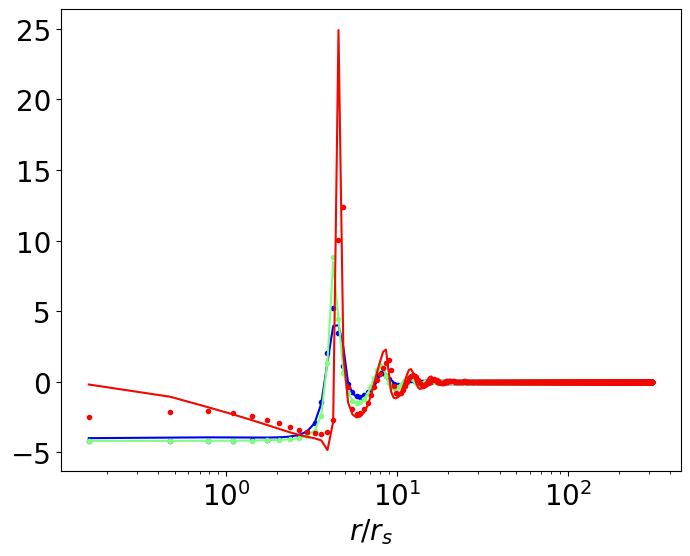

In [273]:
fig, axs = plt.subplots(1,1, figsize=(8,6))
axs = np.array([[axs]])
for i in range(1):
        for j in range(1):
            
#             axs[i,j].plot(atom_list[0].k_array, atom_list[0].c_k_matrix[i,j])
#             axs[i,j].plot(atom_test.k_array, atom_test.c_k_matrix[i,j],'--')
            for k in [1,5,9]:#range(1):
                color = plt.cm.jet(k/10)

#                 axs[i,j].plot(atom_list[0].r_array, atom.FT_k_2_r_matrix(h_k_matrix_list[k])[i,j],'.',color=color)
#                 axs[i,j].plot(atom_list[0].k_array, atom_list[k].c_s_k_matrix[i,j],'--.',color=color)
#                 axs[i,j].plot(atom_test.k_array, atom_test.c_s_k_matrix[i,j],'--')
            
#             axs[i,j].plot(atom_list[0].k_array, atom_list[0].h_k_matrix[i,j])
#             axs[i,j].plot(atom_list[1].k_array, atom_list[1].h_k_matrix[i,j])
#             axs[i,j].plot(atom_test.k_array, atom_test.h_k_matrix[i,j],'--')
                h_k_guess = atom_list[k-1].h_k_matrix[i,j] + (Te_list[k]-Te_list[k-1])*(atom_list[k-1].h_k_matrix[i,j]-atom_list[k-2].h_k_matrix[i,j])/(Te_list[k-1]-Te_list[k-2])
                axs[i,j].plot(atom_list[k].k_array, h_k_guess,'-',color=color)
                axs[i,j].plot(atom_list[k].k_array, atom_list[k].h_k_matrix[i,j],'.',color=color)
#             axs[i,j].plot(atom_list[1].r_array, atom_list[1].h_r_matrix[i,j],'--')
#             axs[i,j].plot(atom_test.r_array, atom_test.h_r_matrix[i,j],'--')

            axs[i,j].tick_params(labelsize=20)
            axs[i,j].set_xscale('log')
#             axs[i,j].set_xlim(2,20)
            axs[i,j].tick_params(labelsize=20)
            axs[-1,j].set_xlabel(r"$r/r_s $",fontsize=20)
#             axs[i,j].set_yscale('symlog',linthresh=0.1)
#             axs[i,j].set_ylim(-10, 1e1)

#         axs[i,0].set_ylabel(r"$c(k)$",fontsize=20)

In [267]:
from scipy.interpolate import interp1d

c_s_k_func_list=[]
# c_s_k_highres_list = []
# h_r_highres_list = []
atom_highres_list = []
for k in range(len(atom_list)):
#     c_s_k_func_list.append( interp1d( atom.k_array, atom_list[k].c_s_k_matrix[i,j]))
    T_k = float(atom_list[k].Temp_list)
    atom_highres, _ = set_hnc_onlyion(ni, T_k, Z, A, Zstar, 
                            pseudopotential=True, oz_type='svt',r_c=r_c, 
                            add_bridge=True, bridge='ocp', N_bins=50, R_max=5)
    func = interp1d( atom.k_array, atom_list[k].c_s_k_matrix[0,0], 
                           fill_value=(atom_list[k].c_s_k_matrix[0,0][0], 0), bounds_error=False )
    atom_highres.c_s_k_matrix[0,0] = func(atom_highres.k_array) 
#     c_s_k_highres_list.append( atom_highres.c_s_k_matrix[0,0] )
    atom_highres.set_all_matrices_from_csk(atom_highres.c_s_k_matrix)
#     _,_,_,_,_,_,_,h_r_highres,_, = atom_highres.get_all_matrices_from_csk(atom_highres.c_s_k_matrix)
#     h_r_highres_list.append(h_r_highres)
    atom_highres_list.append(atom_highres)

Λei = 0.353
Λee = 0.500
Λei adjusted with R = 0.353
Γii=86.140, Γie=-0.235, Γee=0.239 
r_i=0.305
r_e=0.306
r_c=0.525
θ  =1.87e-03
Λei = 0.353
Λee = 0.500
Λei adjusted with R = 0.353
Γii=95.712, Γie=-0.235, Γee=0.239 
r_i=0.305
r_e=0.306
r_c=0.525
θ  =1.69e-03
Λei = 0.353
Λee = 0.500
Λei adjusted with R = 0.353
Γii=107.676, Γie=-0.235, Γee=0.239 
r_i=0.305
r_e=0.306
r_c=0.525
θ  =1.50e-03
Λei = 0.353
Λee = 0.500
Λei adjusted with R = 0.353
Γii=123.058, Γie=-0.235, Γee=0.239 
r_i=0.305
r_e=0.306
r_c=0.525
θ  =1.31e-03
Λei = 0.353
Λee = 0.500
Λei adjusted with R = 0.353
Γii=143.567, Γie=-0.235, Γee=0.239 
r_i=0.305
r_e=0.306
r_c=0.525
θ  =1.12e-03
Λei = 0.353
Λee = 0.500
Λei adjusted with R = 0.353
Γii=172.281, Γie=-0.235, Γee=0.239 
r_i=0.305
r_e=0.306
r_c=0.525
θ  =9.37e-04
Λei = 0.353
Λee = 0.500
Λei adjusted with R = 0.353
Γii=215.351, Γie=-0.235, Γee=0.239 
r_i=0.305
r_e=0.306
r_c=0.525
θ  =7.50e-04
Λei = 0.353
Λee = 0.500
Λei adjusted with R = 0.353
Γii=287.135, Γie=-0.235, Γee=0.23

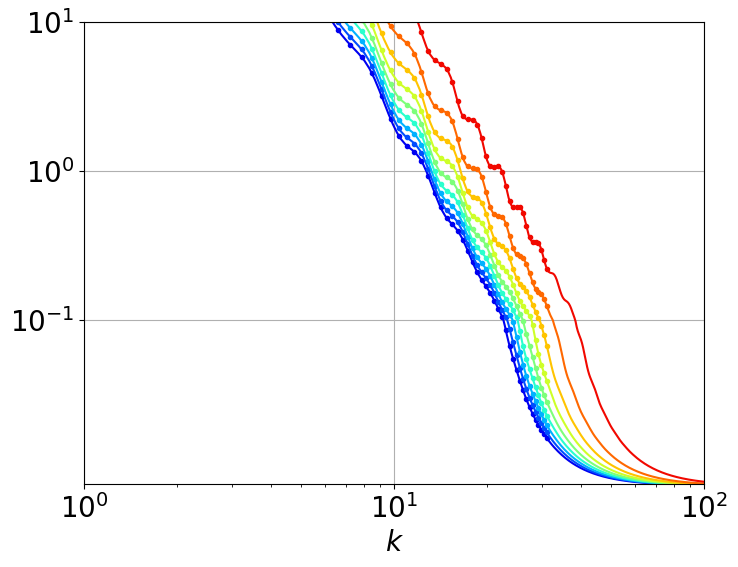

In [247]:
fig, axs = plt.subplots(1,1, figsize=(8,6))
axs = np.array([[axs]])
for i in range(1):
        for j in range(1):
            
            for k in range(1,10):
                color = plt.cm.jet(k/10)

#                 axs[i,j].plot(atom_list[k].r_array, atom_list[k].h_r_matrix[i,j],'-',color=color)
#                 axs[i,j].plot(atom_highres.r_array, atom_highres_list[k].h_r_matrix[i,j],'.',color=color)

                axs[i,j].plot(atom_list[k].k_array, atom_list[k].c_s_k_matrix[i,j],'-',color=color)
                axs[i,j].plot(atom_highres.k_array, atom_highres_list[k].c_s_k_matrix[i,j],'.',color=color)

            axs[i,j].tick_params(labelsize=20)
            axs[i,j].set_xscale('log')
            axs[i,j].set_xlim(1,100)
            axs[i,j].tick_params(labelsize=20)
            axs[-1,j].set_xlabel(r"$k $",fontsize=20)
            axs[i,j].set_yscale('log')
            axs[i,j].set_yscale('symlog',linthresh=0.1)
            axs[i,j].set_ylim(1e-3, 1e1)
            axs[i,j].grid()

#         axs[i,0].set_ylabel(r"$c(k)$",fontsize=20)


In [ ]:
atom.plot_species_convergence_g(n_slices= int(len(atom.h_r_matrix_list)/1)  )

In [ ]:
atom.plot_species_convergence_c(n_slices= int(len(atom.h_r_matrix_list)/10)  )

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(8,6))


# ρ_e = [ np.sum(((h_r_matrix[0,1]+1)*atom.r_array**2)*atom.del_r) for h_r_matrix in atom.h_r_matrix_list]
# ρ_i = [ np.sum(((h_r_matrix[0,0]+1)*atom.r_array**2)*atom.del_r) for h_r_matrix in atom.h_r_matrix_list]

# ρ_e_normal = [ np.sum(((h_r_matrix[0,1]+1)*atom.r_array**2)*atom.del_r) for h_r_matrix in atom_normal.h_r_matrix_list]
# ρ_i_normal = [ np.sum(((h_r_matrix[0,0]+1)*atom.r_array**2)*atom.del_r) for h_r_matrix in atom_normal.h_r_matrix_list]

# # ax.plot(ρ_e ,label=r'$\rho_e$')#, color=color)
# # ax.plot(ρ_i,  '--', label=r'$\rho_i$')#,color=color)
# ax.plot(ρ_e_normal ,label=r'$\rho_e$')#, color=color)
# ax.plot(ρ_i_normal,  '--', label=r'$\rho_i$')#,color=color)
# ax2 = ax.twinx()
# ax2.plot(atom.u_ex_list,'-k')
# ax2.plot(atom_normal.u_ex_list,'--k')

# # ax.set_ylim(8.75,9.2)
# ax2.set_ylim(-1.5,.1)
# ax.legend()

In [ ]:
atom.plot_species_convergence_ck(n_slices= int(len(atom.h_r_matrix_list)/1)  )

In [ ]:
atom.plot_species_convergence_g(n_slices= int(len(atom.h_r_matrix_list)/1)  )
atom.plot_species_convergence_c(n_slices= int(len(atom.h_r_matrix_list)/1)  )

In [ ]:
Al_file = "/home/zach/plasma/datasets/RDFs/Al_1.0eV_rs3_VASP.txt"  # 1 eV
Al_file = '/home/zach/plasma/datasets/RDFs/Al_0.5eV_rs3_KS-MD.txt' # 0.5 eV
Al_data = read_csv(Al_file,header=0, names=['r','g'])

In [ ]:
Te_list[2]/eV

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Al TCCW Case, 1 eV, rs=3', fontsize=20, y=0.95)

ax.plot(Al_data['r'], Al_data['g'],'ro', label = 'VASP' )
# ax.plot(atom.r_array, atom_one_species.h_r_matrix[0,0] + 1, label='No electrons')
ax.plot(atom.r_array, atom.h_r_matrix[0,0] + 1, label='SVT Ashcroft Empy Yukawa Bridge')
# ax.plot(atom.r_array, atomSVT.h_r_matrix[0,0] + 1, label='SVT Ashcroft')
# ax.plot(atom.r_array, atomSVT_Yuk.h_r_matrix[0,0] + 1,'--', label='SVT Ashcroft + Yukawa Bridge')
# ax.plot(atom.r_array, atomSVT_OCP.h_r_matrix[0,0] + 1,'--', label='SVT Ashcroft + OCP Bridge')

ax.set_ylabel(r'$g(r)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(0.5,4)
ax.legend(fontsize=15)


# βu_eff matching

In [ ]:
from pandas import read_csv
from scipy.interpolate import interp1d
# luke_file = '/home/zach/plasma/atomic_forces/data/Al_T0p5_tab.lammps.PAIR'
luke_file = '/home/zach/plasma/atomic_forces/data/Al_T1_tab.lammps.PAIR'

luke_data = read_csv(luke_file ,delim_whitespace=True,header=3, names=['r [A]','V [eV]','F [eV/A]'])
# luke_r, luke_βV = 1e-10/aB/r_s*luke_data['r [A]'], 1/(Te/eV)*luke_data['V [eV]']
luke_r, luke_βV = 1e-8/r_s*luke_data['r [A]'], 1/(Te/eV)*luke_data['V [eV]']
luke_βV_function = interp1d(luke_r, luke_βV,fill_value='extrapolate',bounds_error=False)

In [ ]:
from scipy.optimize import curve_fit

class βu_fit():
    def __init__(self, func, r_array, y_data, initial_guess):
        self.r = r_array
        self.y = y_data
        self.y_vals = curve_fit(func, r_array, y_data, maxfev=int(1e5), p0=initial_guess)
        self.y_fit  = func(r_array, *self.y_vals[0])
        self.err = np.linalg.norm(self.y_fit-self.y)
        print(func.__name__ + " error: {0:.3e} ".format(self.err))

def yukawa_plus(r, a, b, c, d):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d)))

def yukawa_plus_gaussian(r, a ,b ,c, d ,e, f, g):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + e*np.exp(-(f-r)**2/g)

def yukawa_plus_cos(r, a ,b ,c, d , h, i, j, k, l):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + h*np.cos((r-i)*j*np.exp(-k*r))*np.exp(-l*r)

def yukawa_plus_gaussian_cos(r, a ,b ,c, d ,e, f, g, h, i, j, k, l):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + e*np.cos((r-f)*g*np.exp(-h*r))*np.exp(-i*r) + j*np.exp(-(k-r)**2/l)


In [ ]:
atom.invert_HNC([1])
fit1 = βu_fit(yukawa_plus, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[   atomqsp.Γii, atomqsp.get_κ(),2 , 1])
try: 
    fit2 = βu_fit(yukawa_plus_cos, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[  *fit1.y_vals[0], 1, 0.01, 1 , 10, 2])
except:
    pass
try:
    fit3 = βu_fit(yukawa_plus_gaussian_cos, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[  *fit2.y_vals[0], -1, 1.9, 1])
except:
    pass

In [ ]:
luke_r

In [ ]:
fig, ax = plt.subplots(figsize=(8,6),facecolor='w')
fig.suptitle(r"{0} $T=${1:.1f} eV, $r_i$={2:.2f}".format(case_id, Te/eV, atomqsp.ri), fontsize=20)


yukawa_matrix = (atom.Gamma[:,:,np.newaxis]/atom.r_array * np.exp(-atom.r_array*atomqsp.get_κ())[np.newaxis,np.newaxis,:] ) [:-1,:-1]
coulomb_matrix = (atom.Gamma[:,:,np.newaxis]/atom.r_array) [:-1,:-1]

ax.plot(atom.r_array, atom.βu_r_matrix[0,0], 'k--',label='Initial')
ax.plot(atom.r_array, yukawa_matrix[0,0],'k-.', label="Yukawa")

ax.plot(atom.r_array, atom.βueff_r_matrix[0,0],color=colors[0], label='Effective')    
ax.plot(luke_r, luke_βV,'r-', label='Luke Force Match')

ax.set_ylim(np.min([-10, 2*np.min(atom.βueff_r_matrix[0,0])]), np.max([1e3, 2*np.max(atom.βueff_r_matrix[0,0])]))
ax.tick_params(labelsize=20)
ax.set_xlabel(r"$r/r_s$",fontsize=20)
ax.set_ylabel(r'$\beta u(r/r_s)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)

ax.set_xlim(0, R_max)
ax.set_yscale('symlog',linthresh=1)
ax.tick_params(labelsize=15)
ax.legend(fontsize=10)
fig.tight_layout()